In [17]:
import os
import pandas as pd
import numpy as np

# Set project root to ml_project directory
if os.getcwd().endswith('src'):
    os.chdir('..')
    
project_root = os.getcwd()
print(f"Working directory: {project_root}")

# Load reference/lookup tables (used for both train and test)
job_desc_map_df = pd.read_csv("data/code_job_desc_map.csv")
departments_df = pd.read_csv("data/departments.csv")
sports_desc_df = pd.read_csv("data/code_Sports.csv")
city_pop_df = pd.read_csv("data/city_pop.csv")
city_loc_df = pd.read_csv("data/city_loc.csv")
city_loc_df = city_loc_df.drop(columns=['LAT', 'Long'], errors='ignore')
city_adm_df = pd.read_csv("data/city_adm.csv")
city_aav_df = pd.read_excel("data/additional_data/AAV2020.xlsx", sheet_name='Composition_communale', skiprows=5)
city_aav_df = city_aav_df.drop(columns=['LIBGEO', 'LIBAAV2020', 'DEP', 'REG'], errors='ignore')


print(f"✓ Reference tables loaded")

Working directory: /Users/arthur/Documents/Universite/M2-QEA/Machine Learning/final_project/ml_project
✓ Reference tables loaded


In [35]:
def load_and_merge_datasets(dataset_type='learn'):
    """
    Load and merge all datasets for training or testing.
    
    Parameters:
    -----------
    dataset_type : str
        Either 'learn' or 'test'
    
    Returns:
    --------
    tuple: (merged_df, job_cols, retired_cols, pension_cols, sport_cols)
    """
    prefix = f"data/{dataset_type}_dataset"
    
    # Load all datasets
    print(f"\nLoading {dataset_type} datasets...")
    main_df = pd.read_csv(f"{prefix}.csv")
    sport_df = pd.read_csv(f"{prefix}_sport.csv")
    job_df = pd.read_csv(f"{prefix}_job.csv")
    job_security_df = pd.read_csv(f"{prefix}_JOB_SECURITY.csv")
    retired_former_df = pd.read_csv(f"{prefix}_retired_former.csv")
    retired_jobs_df = pd.read_csv(f"{prefix}_retired_jobs.csv")
    retired_pension_df = pd.read_csv(f"{prefix}_retired_pension.csv")
    
    print(f"✓ {dataset_type.capitalize()} datasets loaded: main{main_df.shape}, sport{sport_df.shape}, "
          f"job{job_df.shape}, retired_jobs{retired_jobs_df.shape}, retired_pension{retired_pension_df.shape}")
    
    # Merge with reference tables
    job_df = job_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
    retired_jobs_df = retired_jobs_df.merge(job_desc_map_df, left_on='job_desc', right_on='N3', how='left')
    sport_df = sport_df.merge(sports_desc_df, left_on='Sports', right_on='Code', how='left')
    sport_df = sport_df[['primary_key', 'Sports', 'Categorie']]

    
    # Rename columns with meaningful suffixes
    job_df_renamed = job_df.rename(columns={col: f"{col}_current" for col in job_df.columns if col != 'primary_key'})
    retired_jobs_df_renamed = retired_jobs_df.rename(columns={col: f"{col}_retired" for col in retired_jobs_df.columns if col != 'primary_key'})
    
    # Merge all datasets
    df = main_df.merge(job_df_renamed, on='primary_key', how='left')
    df = df.merge(job_security_df, on='primary_key', how='left')
    df = df.merge(retired_jobs_df_renamed, on='primary_key', how='left')
    df = df.merge(retired_pension_df, on='primary_key', how='left')
    df = df.merge(retired_former_df, on='primary_key', how='left')
    df = df.merge(sport_df, on='primary_key', how='left')
    df = df.merge(city_loc_df, on='Insee_code', how='left')
    df = df.merge(city_adm_df, on='Insee_code', how='left')
    df = df.merge(city_aav_df, left_on='Insee_code', right_on='CODGEO', how='left')
    
    # Save column lists for imputers
    job_cols = [col for col in df.columns if col.endswith('_current')]
    retired_cols = [col for col in df.columns if col.endswith('_retired')]
    pension_cols = [col for col in retired_pension_df.columns if col != 'primary_key' and col in df.columns]
    sport_cols = [col for col in sport_df.columns if col != 'primary_key' and col in df.columns]
    
    print(f"✓ Merged {dataset_type} datasets: {df.shape}")
    print(f"  - Current job columns: {len(job_cols)} (suffix: _current)")
    print(f"  - Retired job columns: {len(retired_cols)} (suffix: _retired)")
    print(f"  - Pension columns: {len(pension_cols)}")
    print(f"  - Sport columns: {len(sport_cols)}")
    
    return df, job_cols, retired_cols, pension_cols, sport_cols


# Load and merge training data
learn_df, job_cols_in_df, retired_cols_in_df, pension_cols_in_df, sport_cols_in_df = load_and_merge_datasets('learn')
test_df, job_cols_in_df, retired_cols_in_df, pension_cols_in_df, sport_cols_in_df = load_and_merge_datasets('test')


Loading learn datasets...
✓ Learn datasets loaded: main(50044, 10), sport(6460, 2), job(19336, 11), retired_jobs(11226, 11), retired_pension(11226, 2)
✓ Merged learn datasets: (50044, 51)
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2

Loading test datasets...
✓ Test datasets loaded: main(50042, 9), sport(6405, 2), job(19277, 11), retired_jobs(11282, 11), retired_pension(11282, 2)
✓ Merged test datasets: (50042, 50)
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2


In [19]:
# Import custom imputers from separate files
import sys
from pathlib import Path

# Add src directory to Python path for custom modules
src_dir = Path(project_root) / 'src'
if str(src_dir) not in sys.path:
    sys.path.insert(0, str(src_dir))

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

# Import custom transformers
from __fn__ActivityTypeImputer import ActivityTypeImputer
from __fn__SportImputer import SportImputer
from __fn__AAV2020Encoder import AAV2020Encoder

from __fn__FarmerImputer import FarmerImputer
from __fn__SelfEmployedImputer import SelfEmployedImputer
from __fn__EmployeeImputer import EmployeeImputer
from __fn__RetiredFarmerImputer import RetiredFarmerImputer
from __fn__RetiredSelfEmployedImputer import RetiredSelfEmployedImputer
from __fn__RetiredEmployeeImputer import RetiredEmployeeImputer

print("✓ All custom imputers imported successfully!")

✓ All custom imputers imported successfully!


In [20]:

# # Create custom transformer instances using saved column lists from merge
# activity_imputer = ActivityTypeImputer(
#     retired_cols=retired_cols_in_df,
#     job_cols=job_cols_in_df,
#     pension_cols=pension_cols_in_df
# )

# sport_imputer = SportImputer(
#     sport_cols=sport_cols_in_df
# )

# farmer_imputer = FarmerImputer()

# self_employed_imputer = SelfEmployedImputer()

# employee_imputer = EmployeeImputer()

# retired_farmer_imputer = RetiredFarmerImputer()

# retired_self_employed_imputer = RetiredSelfEmployedImputer()

# retired_employee_imputer = RetiredEmployeeImputer()

# # Identify column types (after activity imputation will be applied)
# numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# # Remove target and primary_key from features
# if 'target' in numeric_features:
#     numeric_features.remove('target')
# if 'primary_key' in numeric_features:
#     numeric_features.remove('primary_key')
# if 'primary_key' in categorical_features:
#     categorical_features.remove('primary_key')

# print(f"Initial numeric features: {len(numeric_features)}")
# print(f"Initial categorical features: {len(categorical_features)}")

# # Filter categorical features: keep only those with < 100 unique categories
# categorical_features_filtered = []
# categorical_features_dropped = []
# max_categories = 130

# for col in categorical_features:
#     n_unique = df[col].nunique()
#     if n_unique < max_categories:
#         categorical_features_filtered.append(col)
#     else:
#         categorical_features_dropped.append((col, n_unique))

# print(f"\n✓ Categorical features kept (< {max_categories} categories): {len(categorical_features_filtered)}")
# print(f"✗ Categorical features dropped (≥ {max_categories} categories): {len(categorical_features_dropped)}")

# if categorical_features_dropped:
#     print("\nDropped features:")
#     for col, n_unique in categorical_features_dropped:
#         print(f"  - {col}: {n_unique} unique values")

# # Update categorical features list
# categorical_features = categorical_features_filtered

# # Create preprocessing pipelines for numeric and categorical features
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
# ])

# # Combine preprocessing steps
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features),
#         ('cat', categorical_transformer, categorical_features)
#     ])

# # Create full pipeline with custom transformers, preprocessing, and model
# complex_imputation_pipeline = Pipeline(steps=[
#     ('activity_imputer', activity_imputer),        # Activity-type based imputation
#     ('sport_imputer', sport_imputer),              # Sport columns imputation
#     ('self_employed_imputer', self_employed_imputer),  # Self-employed ML-based imputation
#     ('farmer_imputer', farmer_imputer),            # Farmer-specific imputation
#     ('employee_imputer', employee_imputer),        # Employee ML-based imputation
#     ('retired_farmer_imputer', retired_farmer_imputer),  # Retired farmer imputation
#     ('retired_self_employed_imputer', retired_self_employed_imputer),  # Retired self-employed ML-based imputation
#     ('retired_employee_imputer', retired_employee_imputer),  # Retired employee ML-based imputation
#     ('preprocessor', preprocessor),                # Standard preprocessing (impute, scale, encode)
#     ('regressor', HistGradientBoostingRegressor(random_state=42, max_iter=200))
# ])

# print("\n✓ Pipeline created with:")
# print("  1. Activity-type based imputation")
# print("     - Categorical columns → 'not_applicable' for non-applicable cases")
# print("     - Numeric columns (hours/earnings) → 0 for non-applicable cases")
# print("     - Pension income → 0 for non-retired individuals")
# print("  2. Sport columns imputation")
# print("     - All sport columns → 'not_applicable' for missing values")
# print("     - Includes: Sports, Categorie, Nom fédération, Nom catégorie, Code")
# print("     - Handles individuals not in sports_df (exhaustive dataset)")
# print("  3. Self-employed ML-based imputation (Occupation_42 starting with 'csp_2')")
# print("     - WORKING_HOURS_current → ML prediction (HistGradientBoostingRegressor)")
# print("     - Earnings_current → ML prediction (HistGradientBoostingRegressor)")
# print("     - ECONOMIC_SECTOR_current → ML prediction (HistGradientBoostingClassifier)")
# print("     - Models trained on employee data (activity_type == 'type1_1')")
# print("     - Other fields filled with fixed self-employment values")
# print("  4. Farmer-specific imputation (Occupation_42 starting with 'csp_1')")
# print("     - job_desc_current → '100x'")
# print("     - Earnings_current → based on HIGHEST_DIPLOMA (20500-28600)")
# print("     - ECONOMIC_SECTOR_current → 'AZ' (Agriculture)")
# print("     - All other fields filled with fixed agricultural values")
# print("  5. Employee ML-based imputation (activity_type == 'type1_1' with missing job data)")
# print("     - WORKING_HOURS_current → ML prediction (HistGradientBoostingRegressor)")
# print("     - Earnings_current → ML prediction (HistGradientBoostingRegressor)")
# print("     - ECONOMIC_SECTOR_current → ML prediction (HistGradientBoostingClassifier)")
# print("     - terms_of_emp_current → ML prediction (HistGradientBoostingClassifier)")
# print("     - EMPLOYER_TYPE_current → ML prediction (HistGradientBoostingClassifier)")
# print("     - Job hierarchy extracted from Occupation_42")
# print("  6. Retired farmer imputation (Occupation_42 starting with 'csp_7_1' AND activity_type == 'type2_1')")
# print("     - Similar to farmer imputation but for _retired columns")
# print("     - Earnings_retired → based on HIGHEST_DIPLOMA (20500-28600)")
# print("  7. Retired self-employed ML-based imputation (Occupation_42 starting with 'csp_7_2' AND activity_type == 'type2_1')")
# print("     - WORKING_HOURS_retired → ML prediction (HistGradientBoostingRegressor)")
# print("     - ECONOMIC_SECTOR_retired → ML prediction (HistGradientBoostingClassifier)")
# print("     - RETIREMENT_INCOME → based on sex (Female: 870, Male: 1440)")
# print("     - Models trained on retired people data (Occupation_42 starts with 'csp_7')")
# print("  8. Retired employee ML-based imputation (activity_type == 'type2_1' with missing _retired data)")
# print("     - WORKING_HOURS_retired → ML prediction (HistGradientBoostingRegressor)")
# print("     - RETIREMENT_INCOME → ML prediction (HistGradientBoostingRegressor)")
# print("     - ECONOMIC_SECTOR_retired → ML prediction (HistGradientBoostingClassifier)")
# print("     - terms_of_emp_retired → ML prediction (HistGradientBoostingClassifier)")
# print("     - EMPLOYER_TYPE_retired → ML prediction (HistGradientBoostingClassifier)")
# print("     - Models trained on retired people data (Occupation_42 starts with 'csp_7')")
# print("  9. Standard preprocessing (imputation, scaling, encoding)")
# print(f" 10. One-hot encoding only for features with < {max_categories} categories")
# print(" 11. HistGradientBoostingRegressor")

# # For saving preprocessed data, we need to fit_transform the preprocessing steps
# X = df.drop(columns=['target', 'primary_key'], errors='ignore')
# y = df['target'] if 'target' in df.columns else None

# # Apply custom imputation first
# X_imputed = activity_imputer.fit_transform(X)
# X_imputed = sport_imputer.fit_transform(X_imputed)
# X_imputed = self_employed_imputer.fit_transform(X_imputed)
# X_imputed = farmer_imputer.fit_transform(X_imputed)
# X_imputed = employee_imputer.fit_transform(X_imputed)
# X_imputed = retired_farmer_imputer.fit_transform(X_imputed)
# X_imputed = retired_self_employed_imputer.fit_transform(X_imputed)
# X_imputed = retired_employee_imputer.fit_transform(X_imputed)

# # Then apply preprocessing
# main_df_dummies = preprocessor.fit_transform(X_imputed)
# main_df_dummies = pd.DataFrame(
#     main_df_dummies,
#     columns=preprocessor.get_feature_names_out()
# )

# # Add target back if it exists
# if y is not None:

#     main_df_dummies['target'] = y.values

# print(f"\n✓ Preprocessed data shape: {main_df_dummies.shape}")

In [21]:
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# # Prepare data for training
# X = df.drop(columns=['target', 'primary_key'], errors='ignore')
# y = df['target']

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# print("=" * 60)
# print("TRAINING HISTGRADIENTBOOSTING MODEL")
# print("=" * 60)
# print(f"Training set size: {len(X_train)}")
# print(f"Test set size: {len(X_test)}")

# # Fit the full pipeline (includes preprocessing and model)
# print("\nFitting pipeline...")
# complex_imputation_pipeline.fit(X_train, y_train)
# print("✓ Model trained successfully")

# # Make predictions
# y_train_pred = complex_imputation_pipeline.predict(X_train)
# y_test_pred = complex_imputation_pipeline.predict(X_test)

# # Calculate metrics
# train_r2 = r2_score(y_train, y_train_pred)
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_rmse = np.sqrt(train_mse)
# train_mae = mean_absolute_error(y_train, y_train_pred)

# test_r2 = r2_score(y_test, y_test_pred)
# test_mse = mean_squared_error(y_test, y_test_pred)
# test_rmse = np.sqrt(test_mse)
# test_mae = mean_absolute_error(y_test, y_test_pred)

# # Display results
# print("\n" + "=" * 60)
# print("MODEL PERFORMANCE")
# print("=" * 60)
# print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
# print("-" * 60)
# print(f"{'R² Score':<30} {train_r2:<15.4f} {test_r2:<15.4f}")
# print(f"{'Mean Squared Error':<30} {train_mse:<15.4f} {test_mse:<15.4f}")
# print(f"{'Root Mean Squared Error':<30} {train_rmse:<15.4f} {test_rmse:<15.4f}")
# print(f"{'Mean Absolute Error':<30} {train_mae:<15.4f} {test_mae:<15.4f}")
# print("=" * 60)

# # Check for overfitting
# if train_r2 - test_r2 > 0.1:
#     print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2 - test_r2:.4f})")
# else:
#     print(f"\n✓ Good generalization (train R² - test R² = {train_r2 - test_r2:.4f})")

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.base import BaseEstimator, TransformerMixin



# Create custom transformer instances using saved column lists from merge
activity_imputer = ActivityTypeImputer(
    retired_cols=retired_cols_in_df,
    job_cols=job_cols_in_df,
    pension_cols=pension_cols_in_df
)

sport_imputer = SportImputer(
    sport_cols=sport_cols_in_df
)

# Create AAV2020 encoder
aav_encoder = AAV2020Encoder()

# Force specific columns to be treated as categorical (convert to string)
# This prevents them from being detected as numeric_features
force_categorical_cols = ['CATEAVV2020', 'Categorie']
for col in force_categorical_cols:
    if col in df.columns:
        print(f"Converting {col} to string to ensure categorical treatment")
        df[col] = df[col].astype(str)

# Identify column types (after activity imputation will be applied)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove target and primary_key from features
if 'target' in numeric_features:
    numeric_features.remove('target')
if 'primary_key' in numeric_features:
    numeric_features.remove('primary_key')
if 'primary_key' in categorical_features:
    categorical_features.remove('primary_key')

# Filter categorical features for no_imputation_pipeline: keep only those with <= 150 unique categories
max_categories_no_imput = 150
categorical_features_filtered_no_imput = []
categorical_features_dropped_no_imput = []

for col in categorical_features:
    # For AAV2020, skip the filtering since we'll encode it specially
    if col == 'AAV2020':
        categorical_features_filtered_no_imput.append(col)
        continue
    
    n_unique = df[col].nunique()
    if n_unique <= max_categories_no_imput:
        categorical_features_filtered_no_imput.append(col)
    else:
        categorical_features_dropped_no_imput.append((col, n_unique))

print(f"\nNo Imputation Pipeline - Feature Filtering:")
print(f"✓ Categorical features kept (≤ {max_categories_no_imput} categories): {len(categorical_features_filtered_no_imput)}")
print(f"  - Including AAV2020 (will be encoded to top 100 + special categories)")
print(f"✗ Categorical features dropped (> {max_categories_no_imput} categories): {len(categorical_features_dropped_no_imput)}")

if categorical_features_dropped_no_imput:
    print("\nDropped features:")
    for col, n_unique in categorical_features_dropped_no_imput:
        print(f"  - {col}: {n_unique} unique values")

# Create preprocessing pipelines for numeric and categorical features
numeric_transformer_no_imput = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For categorical features, use OrdinalEncoder to convert strings to integers
# This is required for HistGradientBoostingRegressor to handle them as categorical
categorical_transformer_no_imput = OrdinalEncoder(
    handle_unknown='use_encoded_value',
    unknown_value=-1,
    encoded_missing_value=-1
)

# Combine preprocessing steps - only use filtered categorical features
preprocessor_no_imput = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer_no_imput, numeric_features),
        ('cat', categorical_transformer_no_imput, categorical_features_filtered_no_imput)
    ])

# Get the indices of categorical features after preprocessing
# After ColumnTransformer: first come all numeric features, then all categorical features
categorical_feature_indices = list(range(len(numeric_features), len(numeric_features) + len(categorical_features_filtered_no_imput)))

# Create full pipeline with custom transformers, preprocessing, and model
no_imputation_pipeline = Pipeline(steps=[
    ('activity_imputer', activity_imputer),        # Activity-type based imputation
    ('sport_imputer', sport_imputer),              # Sport columns imputation
    ('aav_encoder', aav_encoder),                  # AAV2020 custom encoding
    ('preprocessor', preprocessor_no_imput),       # Standard preprocessing (scale numeric, encode categorical)
    ('regressor', HistGradientBoostingRegressor(
        categorical_features=categorical_feature_indices,
        random_state=42
    ))
])

print(f"\n✓ No Imputation Pipeline created with native categorical feature handling")
print(f"  - Numeric features: {len(numeric_features)}")
print(f"  - Categorical features (ordinal encoded): {len(categorical_features_filtered_no_imput)}")
print(f"  - Categorical feature indices: {categorical_feature_indices}")

Converting Categorie to string to ensure categorical treatment

No Imputation Pipeline - Feature Filtering:
✓ Categorical features kept (≤ 150 categories): 32
  - Including AAV2020 (will be encoded to top 100 + special categories)
✗ Categorical features dropped (> 150 categories): 7

Dropped features:
  - Insee_code: 13640 unique values
  - job_desc_current: 406 unique values
  - N3_current: 406 unique values
  - job_desc_retired: 394 unique values
  - N3_retired: 394 unique values
  - Nom de la commune: 13293 unique values
  - CODGEO: 13594 unique values

✓ No Imputation Pipeline created with native categorical feature handling
  - Numeric features: 9
  - Categorical features (ordinal encoded): 32
  - Categorical feature indices: [9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Prepare data for training
X = df.drop(columns=['target', 'primary_key'], errors='ignore')
y = df['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

print("=" * 60)
print("TRAINING HISTGRADIENTBOOSTING MODEL")
print("=" * 60)
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Fit the full pipeline (includes preprocessing and model)
print("\nFitting pipeline...")
no_imputation_pipeline.fit(X_train, y_train)
print("✓ Model trained successfully")

# Make predictions
y_train_pred = no_imputation_pipeline.predict(X_train)
y_test_pred = no_imputation_pipeline.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_r2 = r2_score(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Display results
print("\n" + "=" * 60)
print("MODEL PERFORMANCE")
print("=" * 60)
print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
print("-" * 60)
print(f"{'R² Score':<30} {train_r2:<15.4f} {test_r2:<15.4f}")
print(f"{'Mean Squared Error':<30} {train_mse:<15.4f} {test_mse:<15.4f}")
print(f"{'Root Mean Squared Error':<30} {train_rmse:<15.4f} {test_rmse:<15.4f}")
print(f"{'Mean Absolute Error':<30} {train_mae:<15.4f} {test_mae:<15.4f}")
print("=" * 60)

# Check for overfitting
if train_r2 - test_r2 > 0.1:
    print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2 - test_r2:.4f})")
else:
    print(f"\n✓ Good generalization (train R² - test R² = {train_r2 - test_r2:.4f})")

TRAINING HISTGRADIENTBOOSTING MODEL
Training set size: 40035
Test set size: 10009

Fitting pipeline...

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104
✓ Model trained successfully

MODEL PERFORMANCE

Metric                         Train           Test           
------------------------------------------------------------
R² Score                       0.8722          0.8266         
Mean Squared Error             0.0121          0.0155         
Root Mean Squared Error        0.1101          0.1246         
Mean Absolute Error            0.0833          0.0938         

✓ Good generalization (train R² - test R² = 0.0456)


In [25]:
import numpy as np
from sklearn.model_selection import KFold
# Must include this to use HalvingSearch
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV

# 1. Define a robust Cross-Validation strategy to prevent the "ordering" issue
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define the parameter distribution
# We focus on the parameters that control the complexity and learning speed
param_dist = {
    'regressor__max_iter': [100, 200, 300],              # Number of boosting rounds
    'regressor__learning_rate': [0.01, 0.05, 0.1, 0.2],   # Step size shrinkage
    'regressor__max_leaf_nodes': [15, 31, 63, 127],      # Complexity of each tree
    'regressor__max_depth': [None, 5, 10, 20],           # Tree depth
    'regressor__min_samples_leaf': [10, 20, 50, 100],    # Regularization
    'regressor__l2_regularization': [0.0, 0.1, 1.0, 10.0] # L2 penalty
}

# 3. Initialize the Halving Search
# factor=2 means in each iteration, the best 1/2 of models are kept
halving_search = HalvingRandomSearchCV(
    estimator=no_imputation_pipeline, # Your existing pipeline
    param_distributions=param_dist,
    factor=2,                          # Successive halving factor
    resource='n_samples',              # We increase the number of samples each round
    min_resources=500,
    max_resources='auto',              # Automatically uses all X_train samples in final round
    scoring='r2',
    cv=cv_strategy,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Starting HalvingRandomSearchCV...")
halving_search.fit(X_train, y_train)

# 4. Results
print(f"\nBest Parameters: {halving_search.best_params_}")
print(f"Best CV R² Score: {halving_search.best_score_:.4f}")

# Evaluate on the hold-out test set
best_model = halving_search.best_estimator_
test_r2 = best_model.score(X_test, y_test)
print(f"Final Test R² with Tuned Model: {test_r2:.4f}")

Starting HalvingRandomSearchCV...
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 500
max_resources_: 40035
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 80
n_resources: 500
Fitting 5 folds for each of 80 candidates, totalling 400 fits

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 106

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special catego


AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 103

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 103

AAV2020 E


AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 103

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 105

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 103

AAV2020 E

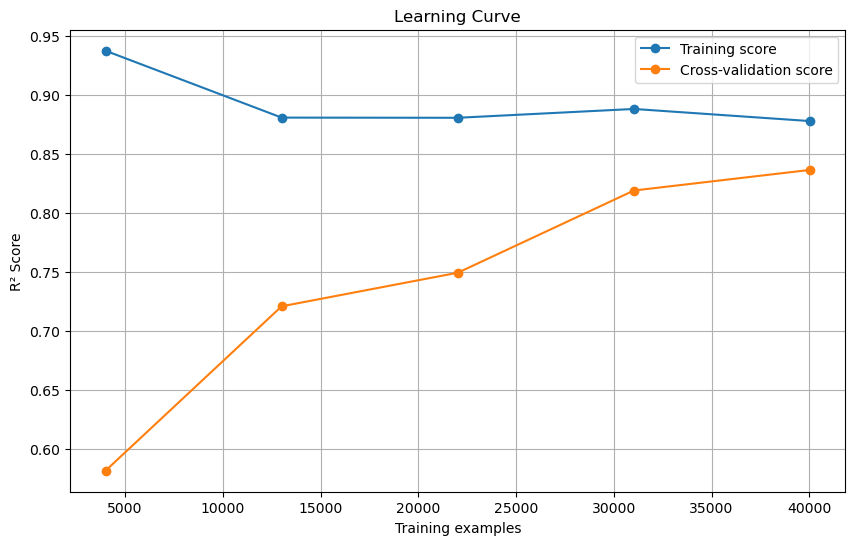

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve, KFold

def plot_learning_curve(estimator, X, y):
    # Create KFold with shuffle=True
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1, 
        train_sizes=np.linspace(0.1, 1.0, 5), scoring="r2"
    )
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    plt.title("Learning Curve")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Run this with your best estimator after the search
plot_learning_curve(halving_search.best_estimator_, X, y)

In [27]:
# # Train model WITHOUT sport data for comparison
# print("=" * 80)
# print("TRAINING MODEL WITHOUT SPORT DATA")
# print("=" * 80)

# # Drop sport columns from the dataframe
# df_no_sport = df.drop(columns=sport_cols_in_df, errors='ignore')
# print(f"Original df shape: {df.shape}")
# print(f"df without sport columns shape: {df_no_sport.shape}")

# # Recreate feature lists without sport columns
# numeric_features_no_sport = df_no_sport.select_dtypes(include=['int64', 'float64']).columns.tolist()
# categorical_features_no_sport = df_no_sport.select_dtypes(include=['object', 'category']).columns.tolist()

# # Remove target and primary_key
# if 'target' in numeric_features_no_sport:
#     numeric_features_no_sport.remove('target')
# if 'primary_key' in numeric_features_no_sport:
#     numeric_features_no_sport.remove('primary_key')
# if 'primary_key' in categorical_features_no_sport:
#     categorical_features_no_sport.remove('primary_key')

# # Filter categorical features (< 100 categories)
# categorical_features_no_sport = [col for col in categorical_features_no_sport 
#                                   if df_no_sport[col].nunique() < max_categories]

# print(f"Numeric features: {len(numeric_features_no_sport)}")
# print(f"Categorical features: {len(categorical_features_no_sport)}")

# # Create preprocessor without sport columns
# preprocessor_no_sport = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numeric_features_no_sport),
#         ('cat', categorical_transformer, categorical_features_no_sport)
#     ])

# # Create pipeline without SportImputer but WITH FarmerImputer
# pipeline_no_sport = Pipeline(steps=[
#     ('activity_imputer', activity_imputer),
#     ('farmer_imputer', farmer_imputer),
#     ('preprocessor', preprocessor_no_sport),
#     ('regressor', HistGradientBoostingRegressor(random_state=42, max_iter=200))
# ])

# # Prepare data
# X_no_sport = df_no_sport.drop(columns=['target', 'primary_key'], errors='ignore')
# y_no_sport = df_no_sport['target']

# # Train-test split
# X_train_no_sport, X_test_no_sport, y_train_no_sport, y_test_no_sport = train_test_split(
#     X_no_sport, y_no_sport, test_size=0.2, random_state=42
# )

# # Train model
# print(f"\nTraining set size: {len(X_train_no_sport)}")
# print(f"Test set size: {len(X_test_no_sport)}")
# print("Fitting pipeline...")
# pipeline_no_sport.fit(X_train_no_sport, y_train_no_sport)
# print("✓ Model trained successfully")

# # Make predictions
# y_train_pred_no_sport = pipeline_no_sport.predict(X_train_no_sport)
# y_test_pred_no_sport = pipeline_no_sport.predict(X_test_no_sport)

# # Calculate metrics
# train_r2_no_sport = r2_score(y_train_no_sport, y_train_pred_no_sport)
# train_rmse_no_sport = np.sqrt(mean_squared_error(y_train_no_sport, y_train_pred_no_sport))
# train_mae_no_sport = mean_absolute_error(y_train_no_sport, y_train_pred_no_sport)

# test_r2_no_sport = r2_score(y_test_no_sport, y_test_pred_no_sport)
# test_rmse_no_sport = np.sqrt(mean_squared_error(y_test_no_sport, y_test_pred_no_sport))
# test_mae_no_sport = mean_absolute_error(y_test_no_sport, y_test_pred_no_sport)

# # Display results
# print("\n" + "=" * 80)
# print("MODEL PERFORMANCE (WITHOUT SPORT DATA)")
# print("=" * 80)
# print(f"\n{'Metric':<30} {'Train':<15} {'Test':<15}")
# print("-" * 80)
# print(f"{'R² Score':<30} {train_r2_no_sport:<15.4f} {test_r2_no_sport:<15.4f}")
# print(f"{'Root Mean Squared Error':<30} {train_rmse_no_sport:<15.4f} {test_rmse_no_sport:<15.4f}")
# print(f"{'Mean Absolute Error':<30} {train_mae_no_sport:<15.4f} {test_mae_no_sport:<15.4f}")
# print("=" * 80)

# if train_r2_no_sport - test_r2_no_sport > 0.1:
#     print(f"\n⚠️  Warning: Possible overfitting detected (train R² - test R² = {train_r2_no_sport - test_r2_no_sport:.4f})")
# else:
#     print(f"\n✓ Good generalization (train R² - test R² = {train_r2_no_sport - test_r2_no_sport:.4f})")

In [28]:
# Analysis: People with missing job_desc_current by Occupation_42
print("=" * 80)
print("ANALYSIS: MISSING JOB_DESC_CURRENT BY OCCUPATION_42")
print("=" * 80)

# Step 1: Filter people with missing job_desc_current
missing_job_desc = df[df['job_desc_current'].isna()].copy()
print(f"\n1. People with missing job_desc_current: {len(missing_job_desc)}")

# Step 2: Get unique Occupation_42 values from those with missing job_desc_current
occupation_values = missing_job_desc['Occupation_42'].dropna().unique()
print(f"\n2. Unique Occupation_42 values in missing group: {len(occupation_values)}")

# Step 3: For each Occupation_42, count people with same value but NON-missing job_desc_current
# and calculate mode of job columns
results = []

for occ in occupation_values:
    # Get people with this Occupation_42 who HAVE job_desc_current
    same_occ_with_job = df[(df['Occupation_42'] == occ) & (df['job_desc_current'].notna())].copy()
    
    # Count
    count_with_data = len(same_occ_with_job)
    
    # Calculate mode for all job_df columns (those ending with _current)
    mode_data = {'Occupation_42': occ, 'count_with_job_desc': count_with_data}
    
    if count_with_data > 0:
        # For each job column, calculate mode
        for col in job_cols_in_df:
            if col in same_occ_with_job.columns:
                mode_values = same_occ_with_job[col].mode()
                if len(mode_values) > 0:
                    mode_data[col] = mode_values.iloc[0]
                else:
                    mode_data[col] = None
    else:
        # No data available
        for col in job_cols_in_df:
            mode_data[col] = None
    
    results.append(mode_data)

# Create DataFrame
results_df = pd.DataFrame(results)

print(f"\n3. Results summary:")
print(f"   - Total Occupation_42 categories analyzed: {len(results_df)}")
print(f"   - Categories with reference data (count > 0): {(results_df['count_with_job_desc'] > 0).sum()}")
print(f"   - Categories with NO reference data (count = 0): {(results_df['count_with_job_desc'] == 0).sum()}")

# Display the table
print("\n" + "=" * 80)
print("RESULTS TABLE")
print("=" * 80)
print(f"\nShowing first 10 rows (total: {len(results_df)} rows):\n")
display(results_df.head(10))

print(f"\n✓ Full table stored in 'results_df' variable")
print(f"  Shape: {results_df.shape}")
print(f"  Columns: {list(results_df.columns)}")

ANALYSIS: MISSING JOB_DESC_CURRENT BY OCCUPATION_42

1. People with missing job_desc_current: 30708

2. Unique Occupation_42 values in missing group: 41

3. Results summary:
   - Total Occupation_42 categories analyzed: 41
   - Categories with reference data (count > 0): 24
   - Categories with NO reference data (count = 0): 17

RESULTS TABLE

Showing first 10 rows (total: 41 rows):



ANALYSIS: MISSING JOB_DESC_CURRENT BY OCCUPATION_42

1. People with missing job_desc_current: 30708

2. Unique Occupation_42 values in missing group: 41

3. Results summary:
   - Total Occupation_42 categories analyzed: 41
   - Categories with reference data (count > 0): 24
   - Categories with NO reference data (count = 0): 17

RESULTS TABLE

Showing first 10 rows (total: 41 rows):



,Occupation_42,count_with_job_desc,job_desc_current,Work_condition_current,terms_of_emp_current,Earnings_current,OCCUPATIONAL_STATUS_current,ECONOMIC_SECTOR_current,EMPLOYER_TYPE_current,WORKING_HOURS_current,Job_dep_current,Employee_count_current,N3_current,N2_current,N1_current
0,csp_7_8,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
1,csp_7_4,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
2,csp_8_4,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
3,csp_7_5,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
4,csp_7_7,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
5,csp_6_7,936,676c,C,CDI,1082.0,O,NZ,ct_9,1820.0,59,tr_1,676c,csp_6_7,csp_6
6,csp_7_1,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
7,csp_8_5,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
8,csp_2_1,0,None,None,None,NaN,None,None,None,NaN,None,None,None,None,None
9,csp_3_5,113,352a,C,CDI,1307.0,O,JA,ct_9,1820.0,75,tr_6,352a,csp_3_5,csp_3



✓ Full table stored in 'results_df' variable
  Shape: (41, 15)
  Columns: ['Occupation_42', 'count_with_job_desc', 'job_desc_current', 'Work_condition_current', 'terms_of_emp_current', 'Earnings_current', 'OCCUPATIONAL_STATUS_current', 'ECONOMIC_SECTOR_current', 'EMPLOYER_TYPE_current', 'WORKING_HOURS_current', 'Job_dep_current', 'Employee_count_current', 'N3_current', 'N2_current', 'N1_current']


PERMUTATION IMPORTANCE ANALYSIS

Computing permutation importance (this may take a moment)...
✓ Permutation importance computed

TOP 30 MOST IMPORTANT FEATURES
                    feature  importance_mean  importance_std
                     Sports         0.871558        0.012738
                        Dep         0.207187        0.006191
            HIGHEST_DIPLOMA         0.142339        0.002969
              Occupation_42         0.112310        0.001854
                   AGE_2018         0.080717        0.003164
                        sex         0.060960        0.001957
                  town_type         0.033011        0.001291
              activity_type         0.030172        0.000499
               JOB_SECURITY         0.015220        0.000913
                    AAV2020         0.012811        0.000547
    ECONOMIC_SECTOR_current         0.007378        0.000277
                CATEAAV2020         0.004754        0.000212
            Job_dep_current         0.004590   

PERMUTATION IMPORTANCE ANALYSIS

Computing permutation importance (this may take a moment)...
✓ Permutation importance computed

TOP 30 MOST IMPORTANT FEATURES
                    feature  importance_mean  importance_std
                     Sports         0.871558        0.012738
                        Dep         0.207187        0.006191
            HIGHEST_DIPLOMA         0.142339        0.002969
              Occupation_42         0.112310        0.001854
                   AGE_2018         0.080717        0.003164
                        sex         0.060960        0.001957
                  town_type         0.033011        0.001291
              activity_type         0.030172        0.000499
               JOB_SECURITY         0.015220        0.000913
                    AAV2020         0.012811        0.000547
    ECONOMIC_SECTOR_current         0.007378        0.000277
                CATEAAV2020         0.004754        0.000212
            Job_dep_current         0.004590   

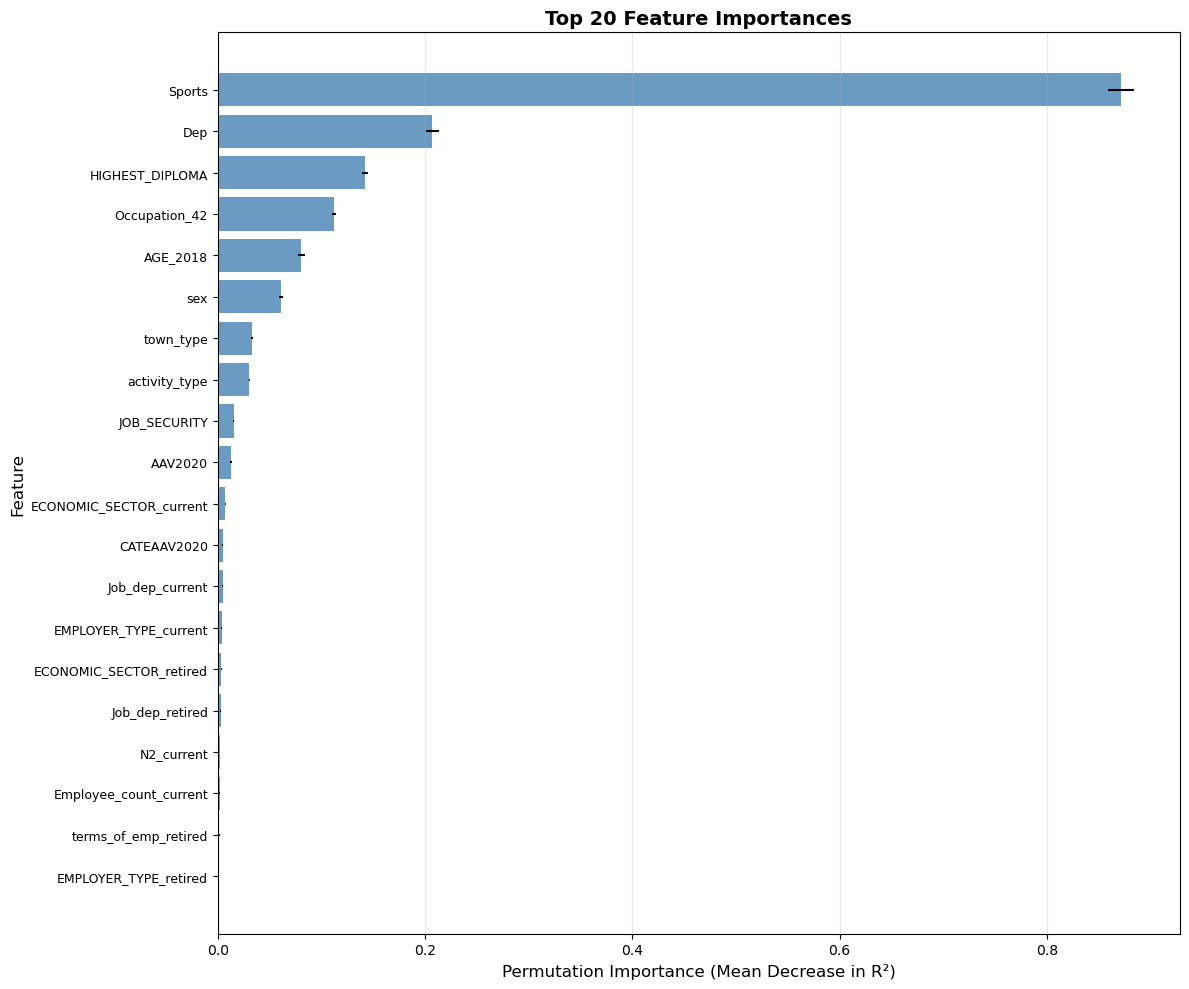


✓ Visualization complete for top 20 features

IMPORTANCE STATISTICS
Total features: 49
Features with positive importance: 36
Features with negative importance: 3
Features with near-zero importance (|imp| < 0.001): 26


In [29]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

print("=" * 80)
print("PERMUTATION IMPORTANCE ANALYSIS")
print("=" * 80)

# Compute permutation importance on test set
print("\nComputing permutation importance (this may take a moment)...")
perm_importance = permutation_importance(
    no_imputation_pipeline, 
    X_test, 
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

print("✓ Permutation importance computed")

# Get feature names from X_test (input features, not transformed)
feature_names = X_test.columns.tolist()

# Create dataframe with feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm_importance.importances_mean,
    'importance_std': perm_importance.importances_std
})

# Sort by importance
importance_df = importance_df.sort_values('importance_mean', ascending=False)

# Display top 30 features
print("\n" + "=" * 80)
print("TOP 30 MOST IMPORTANT FEATURES")
print("=" * 80)
print(importance_df.head(50).to_string(index=False))

# Visualize top 30 features
top_n = 20
top_features = importance_df.head(top_n)

plt.figure(figsize=(12, 10))
plt.barh(range(len(top_features)), top_features['importance_mean'], 
         xerr=top_features['importance_std'], 
         align='center', alpha=0.8, color='steelblue')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=9)
plt.xlabel('Permutation Importance (Mean Decrease in R²)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✓ Visualization complete for top {top_n} features")

# Show summary statistics
print("\n" + "=" * 80)
print("IMPORTANCE STATISTICS")
print("=" * 80)
print(f"Total features: {len(importance_df)}")
print(f"Features with positive importance: {(importance_df['importance_mean'] > 0).sum()}")
print(f"Features with negative importance: {(importance_df['importance_mean'] < 0).sum()}")
print(f"Features with near-zero importance (|imp| < 0.001): {(importance_df['importance_mean'].abs() < 0.001).sum()}")

OUTLIER ANALYSIS - BADLY PREDICTED VALUES

Defining outlier categories...
--------------------------------------------------------------------------------
Absolute Error Statistics:
  Mean: 0.09
  Median: 0.07
  Std Dev: 0.08
  95th percentile: 0.25
  99th percentile: 0.36

Outlier Thresholds:
  Mean + 2*std: 0.26
  Mean + 3*std: 0.34

OUTLIER DISTRIBUTION
outlier_category
normal              9508
moderate_outlier     400
extreme_outlier      101
Name: count, dtype: int64

Percentages:
outlier_category
normal              94.99
moderate_outlier     4.00
extreme_outlier      1.01
Name: count, dtype: float64

EXTREME OUTLIERS ANALYSIS (Top 1%, n=101)

Top 10 worst predictions:
         actual  predicted  abs_error  pct_error  residual
48676  4.762244   3.692516   1.069728  22.462691  1.069728
31360  4.505876   3.707365   0.798511  17.721548  0.798511
37377  1.589090   2.351663   0.762573  47.988063 -0.762573
43674  3.007747   3.751276   0.743529  24.720449 -0.743529
257    4.342153   3.6

OUTLIER ANALYSIS - BADLY PREDICTED VALUES

Defining outlier categories...
--------------------------------------------------------------------------------
Absolute Error Statistics:
  Mean: 0.09
  Median: 0.07
  Std Dev: 0.08
  95th percentile: 0.25
  99th percentile: 0.36

Outlier Thresholds:
  Mean + 2*std: 0.26
  Mean + 3*std: 0.34

OUTLIER DISTRIBUTION
outlier_category
normal              9508
moderate_outlier     400
extreme_outlier      101
Name: count, dtype: int64

Percentages:
outlier_category
normal              94.99
moderate_outlier     4.00
extreme_outlier      1.01
Name: count, dtype: float64

EXTREME OUTLIERS ANALYSIS (Top 1%, n=101)

Top 10 worst predictions:
         actual  predicted  abs_error  pct_error  residual
48676  4.762244   3.692516   1.069728  22.462691  1.069728
31360  4.505876   3.707365   0.798511  17.721548  0.798511
37377  1.589090   2.351663   0.762573  47.988063 -0.762573
43674  3.007747   3.751276   0.743529  24.720449 -0.743529
257    4.342153   3.6

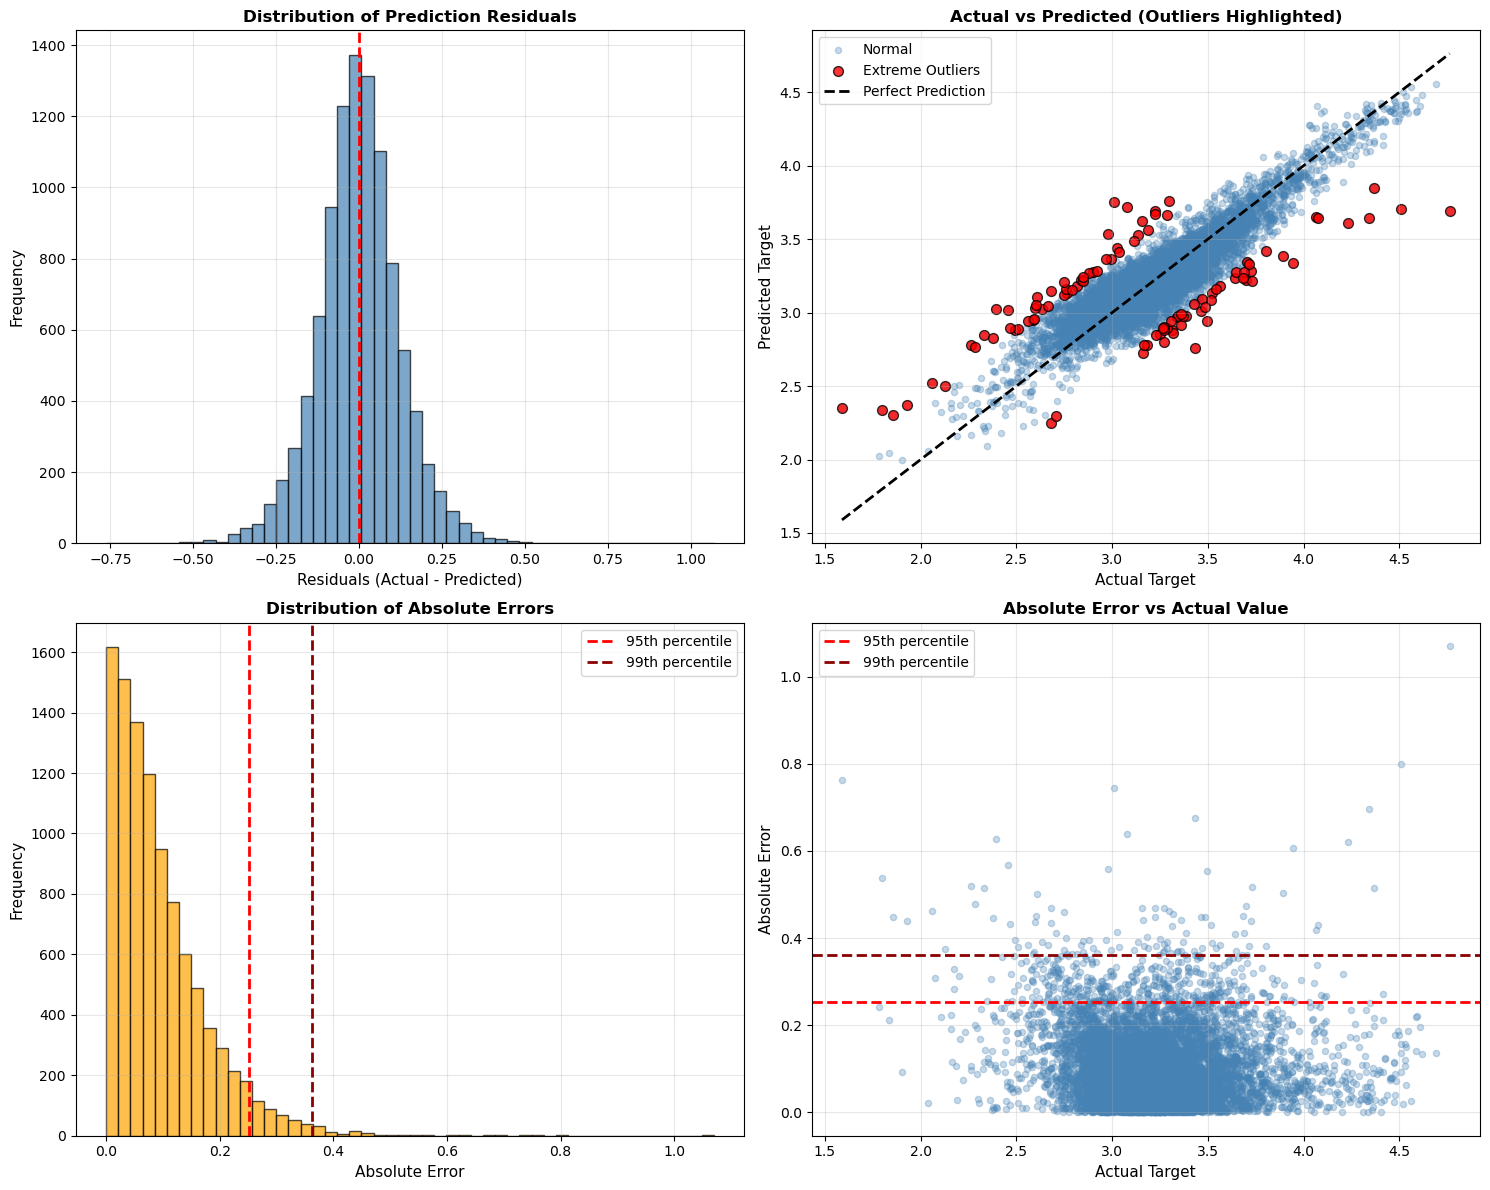


✓ Outlier analysis complete
✓ Outlier dataframe stored in 'outlier_df' variable with 10009 rows


In [30]:
print("=" * 80)
print("OUTLIER ANALYSIS - BADLY PREDICTED VALUES")
print("=" * 80)

# Calculate prediction errors (residuals)
test_residuals = y_test - y_test_pred
test_abs_errors = np.abs(test_residuals)
test_pct_errors = (test_abs_errors / y_test) * 100

# Create analysis dataframe
outlier_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred,
    'residual': test_residuals.values,
    'abs_error': test_abs_errors.values,
    'pct_error': test_pct_errors.values
}, index=y_test.index)

# Add features for analysis
outlier_df = pd.concat([outlier_df, X_test], axis=1)

# Define outlier thresholds
print("\nDefining outlier categories...")
print("-" * 80)

# Method 1: Based on percentiles of absolute error
p95_error = np.percentile(test_abs_errors, 95)
p99_error = np.percentile(test_abs_errors, 99)

# Method 2: Based on standard deviations
mean_error = test_abs_errors.mean()
std_error = test_abs_errors.std()
outlier_threshold_2std = mean_error + 2 * std_error
outlier_threshold_3std = mean_error + 3 * std_error

print(f"Absolute Error Statistics:")
print(f"  Mean: {mean_error:.2f}")
print(f"  Median: {np.median(test_abs_errors):.2f}")
print(f"  Std Dev: {std_error:.2f}")
print(f"  95th percentile: {p95_error:.2f}")
print(f"  99th percentile: {p99_error:.2f}")
print(f"\nOutlier Thresholds:")
print(f"  Mean + 2*std: {outlier_threshold_2std:.2f}")
print(f"  Mean + 3*std: {outlier_threshold_3std:.2f}")

# Categorize predictions
outlier_df['outlier_category'] = 'normal'
outlier_df.loc[outlier_df['abs_error'] > p95_error, 'outlier_category'] = 'moderate_outlier'
outlier_df.loc[outlier_df['abs_error'] > p99_error, 'outlier_category'] = 'extreme_outlier'

# Count outliers
print("\n" + "=" * 80)
print("OUTLIER DISTRIBUTION")
print("=" * 80)
outlier_counts = outlier_df['outlier_category'].value_counts()
print(outlier_counts)
print(f"\nPercentages:")
print((outlier_counts / len(outlier_df) * 100).round(2))

# Analyze extreme outliers
extreme_outliers = outlier_df[outlier_df['outlier_category'] == 'extreme_outlier'].copy()
print("\n" + "=" * 80)
print(f"EXTREME OUTLIERS ANALYSIS (Top 1%, n={len(extreme_outliers)})")
print("=" * 80)

if len(extreme_outliers) > 0:
    print("\nTop 10 worst predictions:")
    worst_predictions = extreme_outliers.nlargest(10, 'abs_error')[
        ['actual', 'predicted', 'abs_error', 'pct_error', 'residual']
    ]
    print(worst_predictions.to_string())
    
    # Analyze characteristics of extreme outliers
    print("\n" + "=" * 80)
    print("CHARACTERISTICS OF EXTREME OUTLIERS")
    print("=" * 80)
    
    # Categorical features analysis
    categorical_cols = ['activity_type', 'Occupation_42', 'HIGHEST_DIPLOMA', 
                       'Household', 'JOB_SECURITY', 'OCCUPATIONAL_STATUS_current']
    
    for col in categorical_cols:
        if col in extreme_outliers.columns:
            print(f"\n{col} distribution in extreme outliers:")
            value_counts = extreme_outliers[col].value_counts().head(5)
            print(value_counts)
    
    # Numeric features analysis
    numeric_cols = ['age', 'Earnings_current', 'WORKING_HOURS_current']
    
    print("\n" + "=" * 80)
    print("NUMERIC FEATURES - EXTREME OUTLIERS vs ALL DATA")
    print("=" * 80)
    for col in numeric_cols:
        if col in extreme_outliers.columns:
            outlier_mean = extreme_outliers[col].mean()
            all_mean = X_test[col].mean()
            outlier_median = extreme_outliers[col].median()
            all_median = X_test[col].median()
            print(f"\n{col}:")
            print(f"  Outliers - Mean: {outlier_mean:.2f}, Median: {outlier_median:.2f}")
            print(f"  All data - Mean: {all_mean:.2f}, Median: {all_median:.2f}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Residuals distribution
axes[0, 0].hist(test_residuals, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Residuals (Actual - Predicted)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Distribution of Prediction Residuals', fontsize=12, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# 2. Actual vs Predicted with outliers highlighted
axes[0, 1].scatter(y_test, y_test_pred, alpha=0.3, s=20, label='Normal', color='steelblue')
if len(extreme_outliers) > 0:
    axes[0, 1].scatter(extreme_outliers['actual'], extreme_outliers['predicted'], 
                      alpha=0.8, s=50, label='Extreme Outliers', color='red', edgecolor='black')
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
               'k--', linewidth=2, label='Perfect Prediction')
axes[0, 1].set_xlabel('Actual Target', fontsize=11)
axes[0, 1].set_ylabel('Predicted Target', fontsize=11)
axes[0, 1].set_title('Actual vs Predicted (Outliers Highlighted)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Absolute error distribution
axes[1, 0].hist(test_abs_errors, bins=50, alpha=0.7, color='orange', edgecolor='black')
axes[1, 0].axvline(x=p95_error, color='red', linestyle='--', linewidth=2, label='95th percentile')
axes[1, 0].axvline(x=p99_error, color='darkred', linestyle='--', linewidth=2, label='99th percentile')
axes[1, 0].set_xlabel('Absolute Error', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Distribution of Absolute Errors', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# 4. Error vs Actual value
axes[1, 1].scatter(y_test, test_abs_errors, alpha=0.3, s=20, color='steelblue')
axes[1, 1].axhline(y=p95_error, color='red', linestyle='--', linewidth=2, label='95th percentile')
axes[1, 1].axhline(y=p99_error, color='darkred', linestyle='--', linewidth=2, label='99th percentile')
axes[1, 1].set_xlabel('Actual Target', fontsize=11)
axes[1, 1].set_ylabel('Absolute Error', fontsize=11)
axes[1, 1].set_title('Absolute Error vs Actual Value', fontsize=12, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✓ Outlier analysis complete")
print(f"✓ Outlier dataframe stored in 'outlier_df' variable with {len(outlier_df)} rows")


Sports has 88 unique values - showing top 10 categories


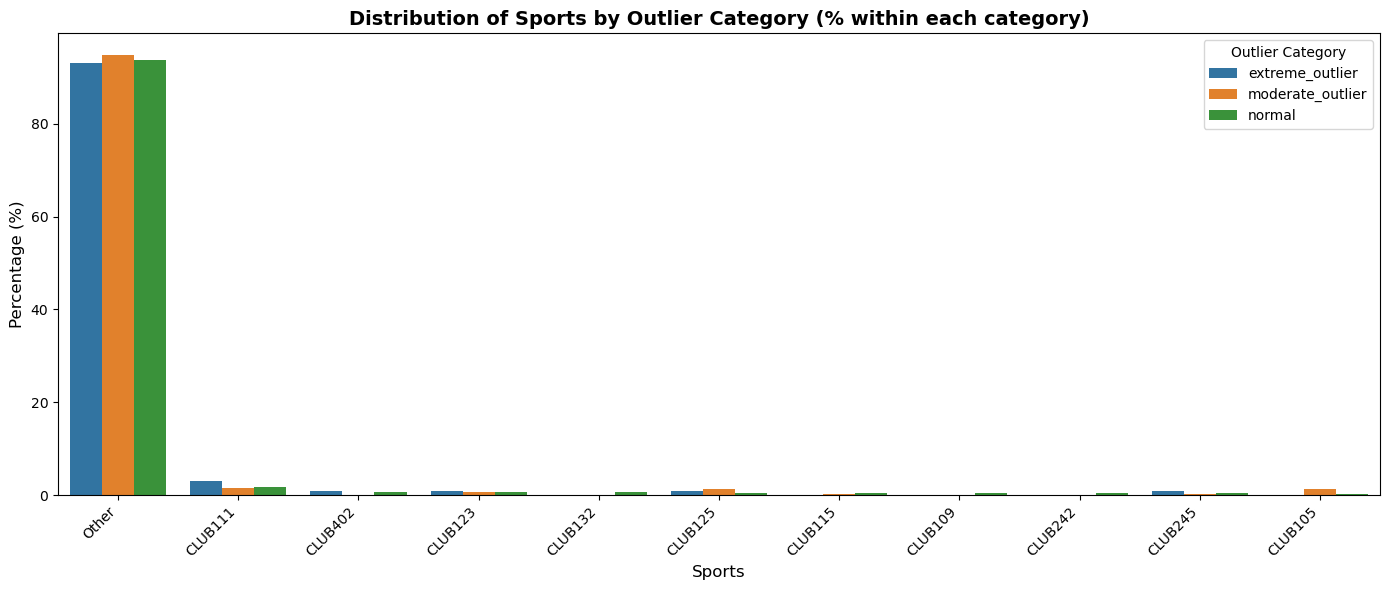


Sports has 88 unique values - showing top 10 categories


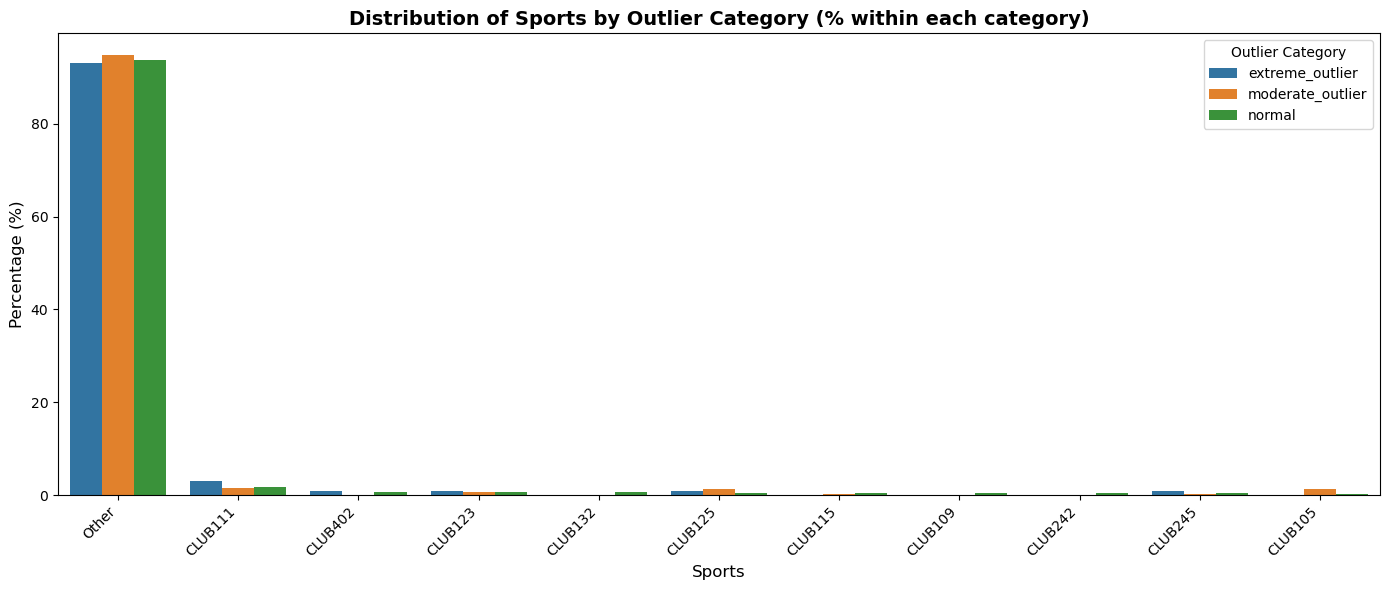

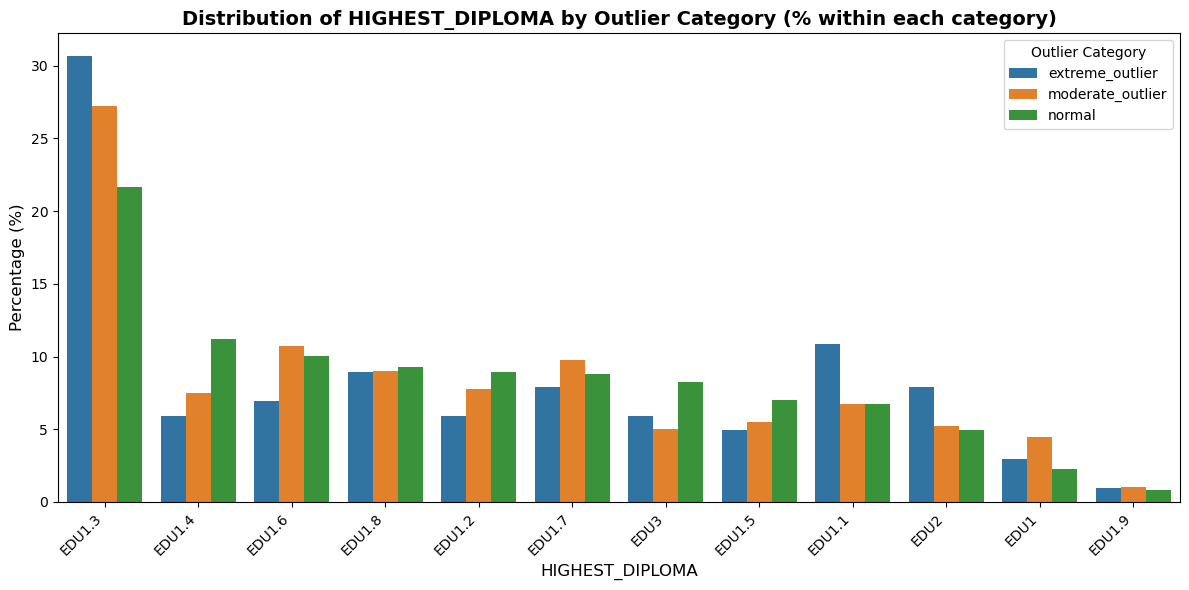


Sports has 88 unique values - showing top 10 categories


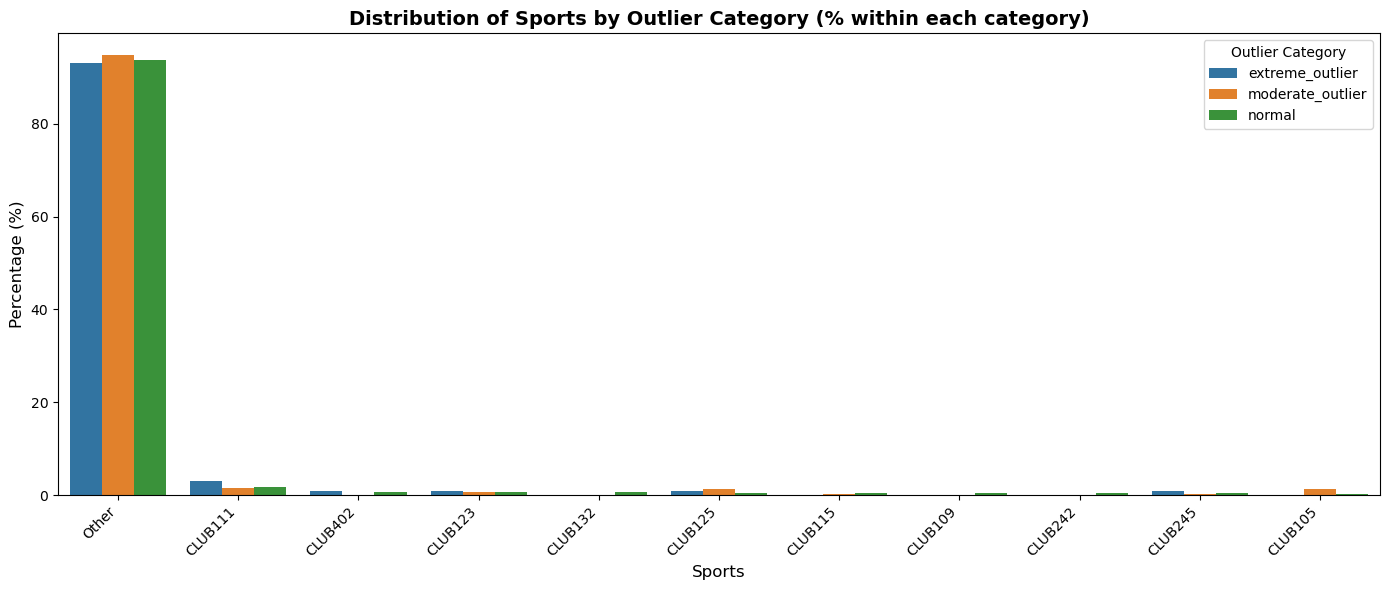

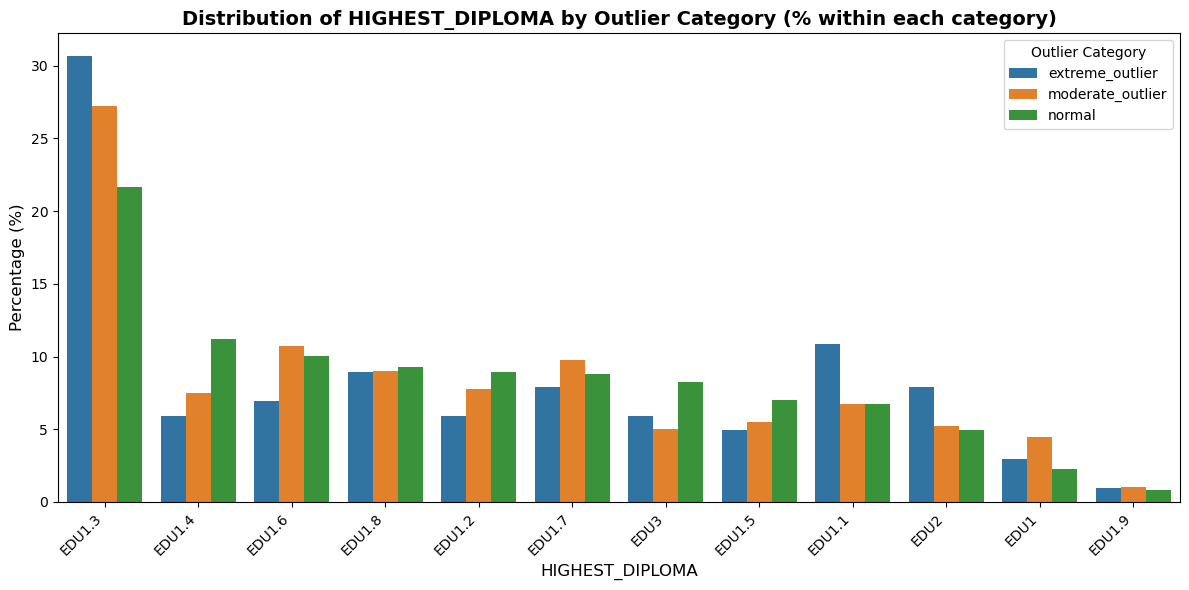


Occupation_42 has 41 unique values - showing top 10 categories


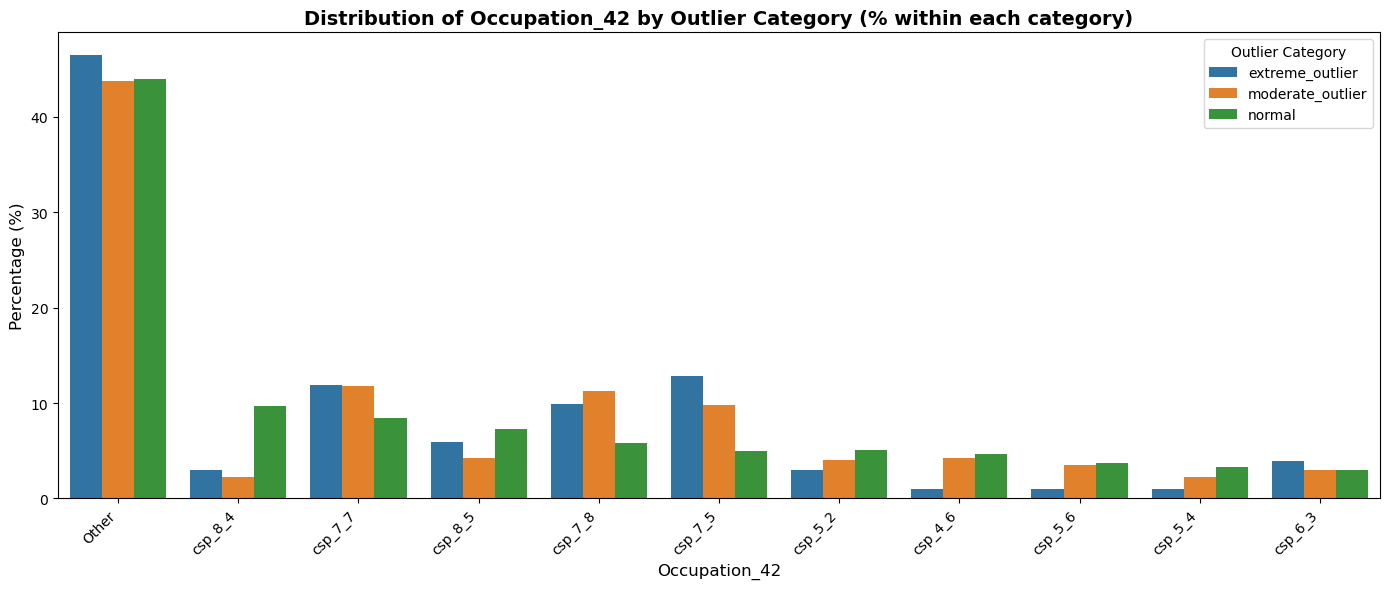


Sports has 88 unique values - showing top 10 categories


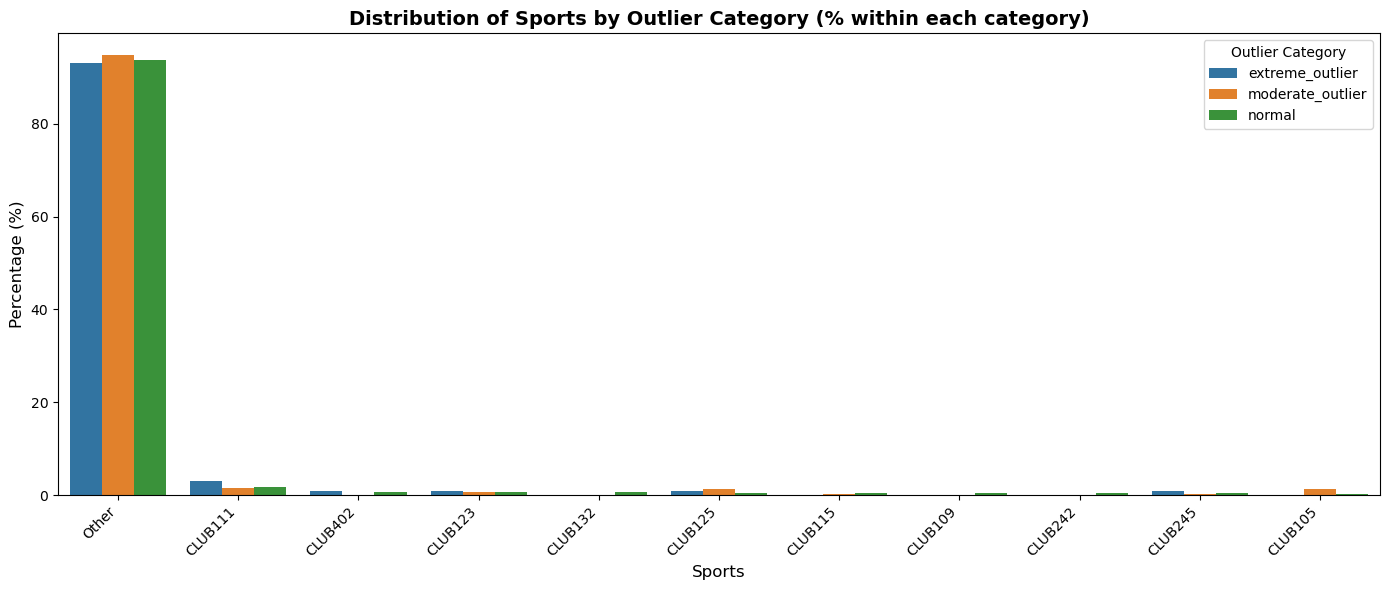

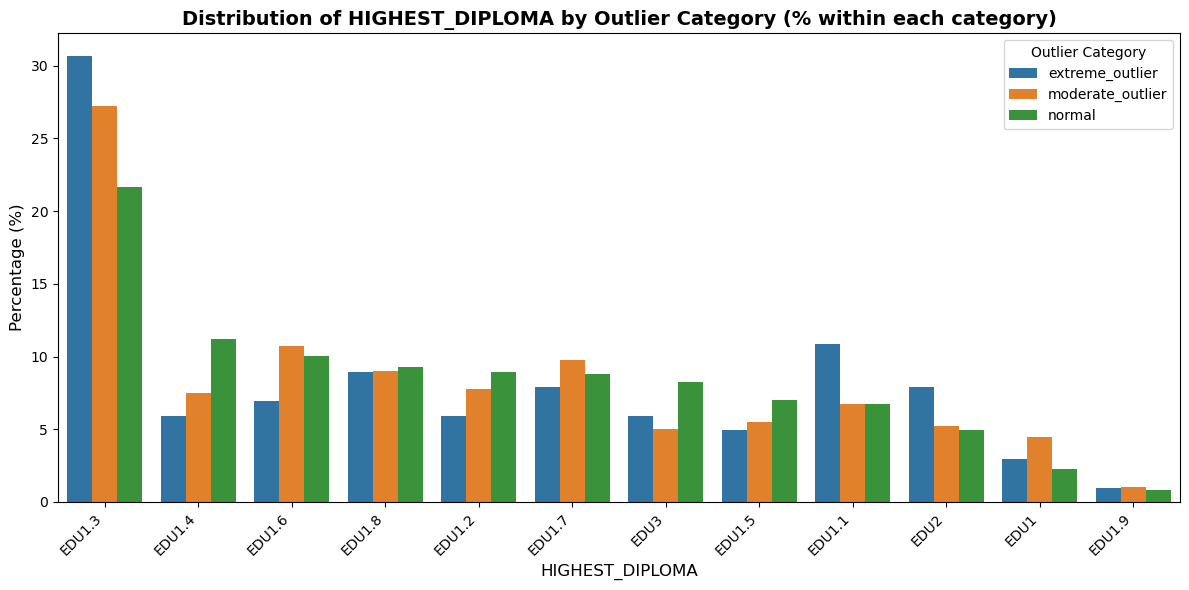


Occupation_42 has 41 unique values - showing top 10 categories


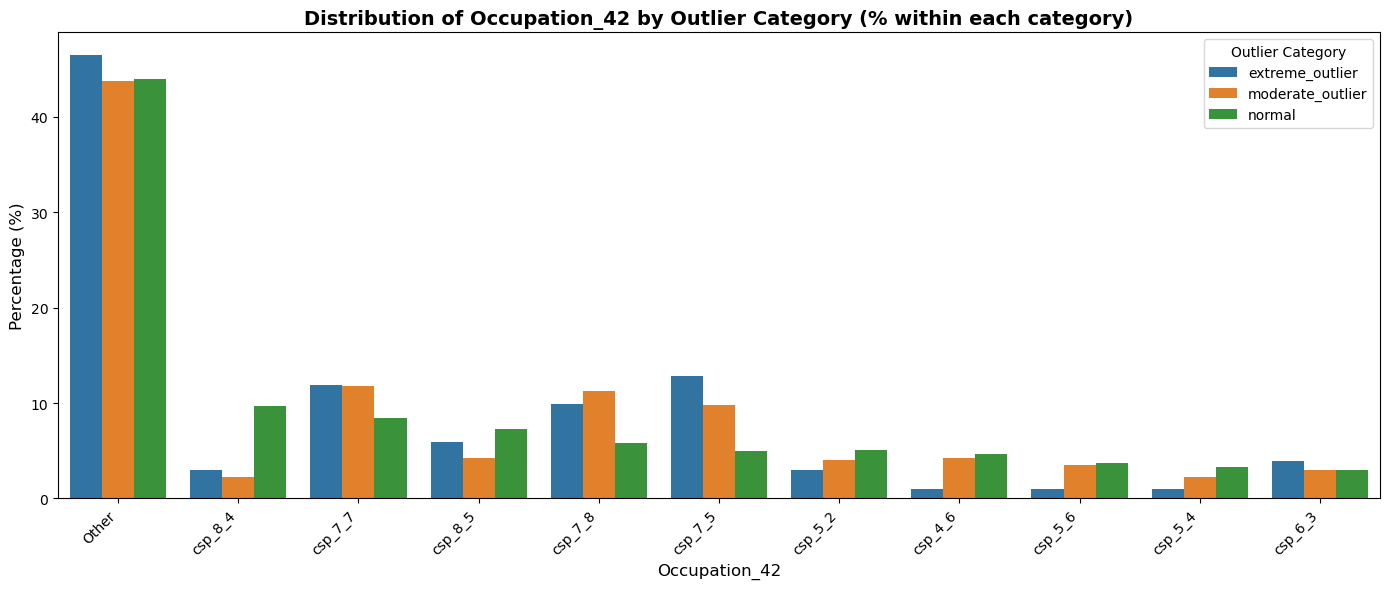


AGE_2018 has 89 unique values - showing top 10 categories



Sports has 88 unique values - showing top 10 categories


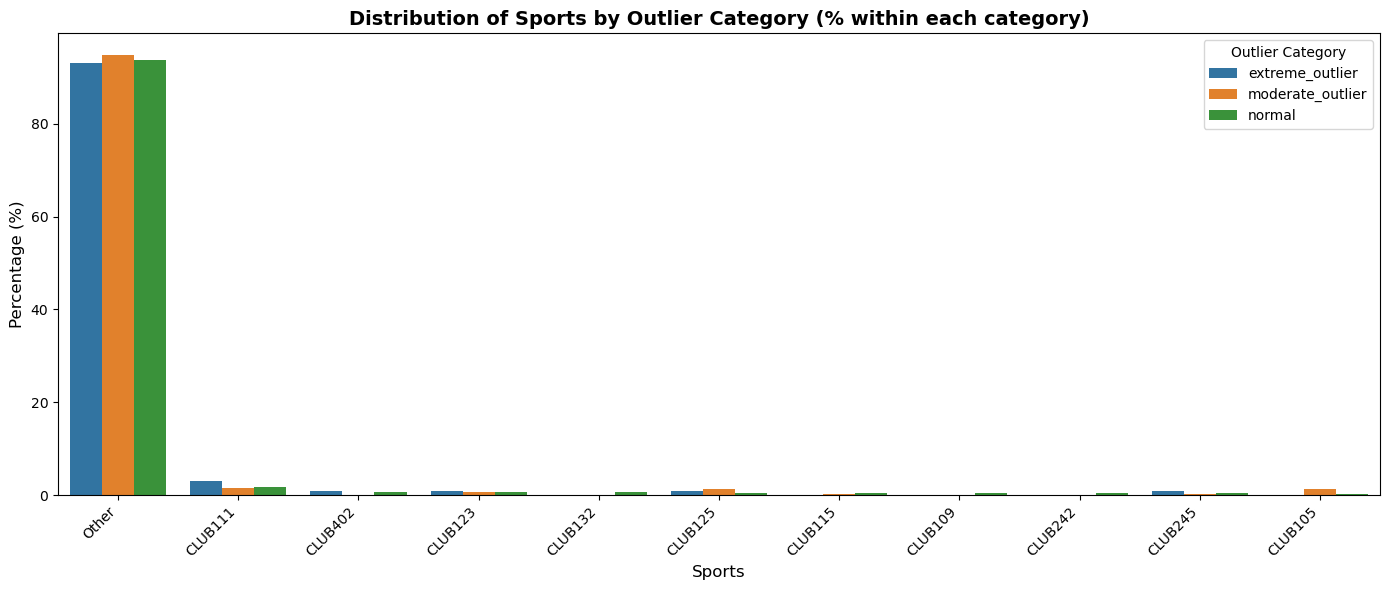

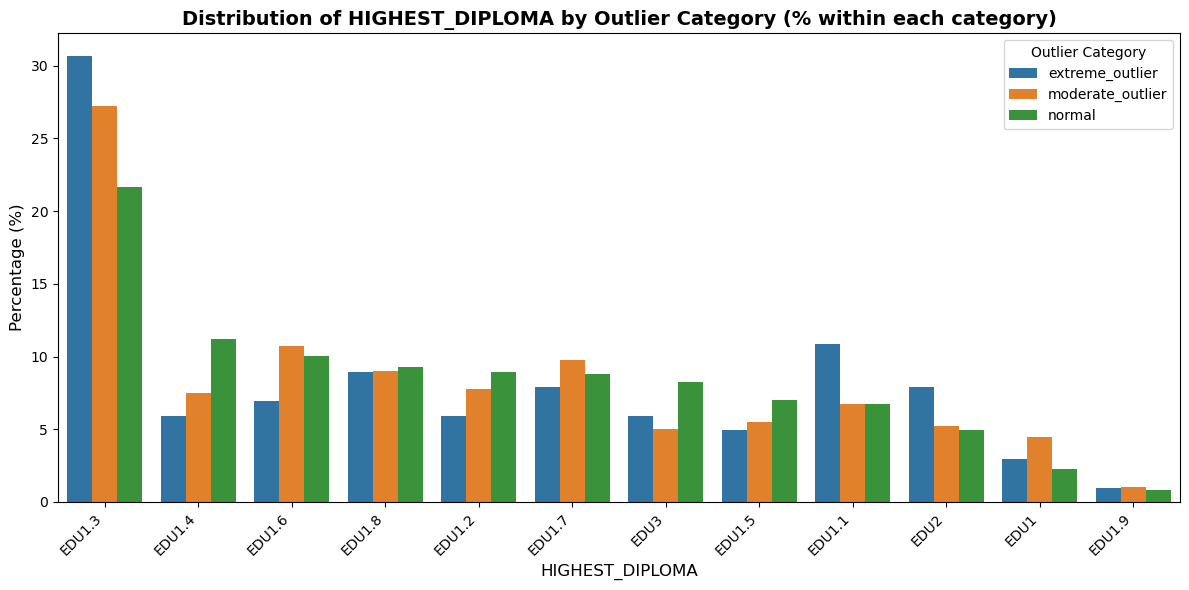


Occupation_42 has 41 unique values - showing top 10 categories


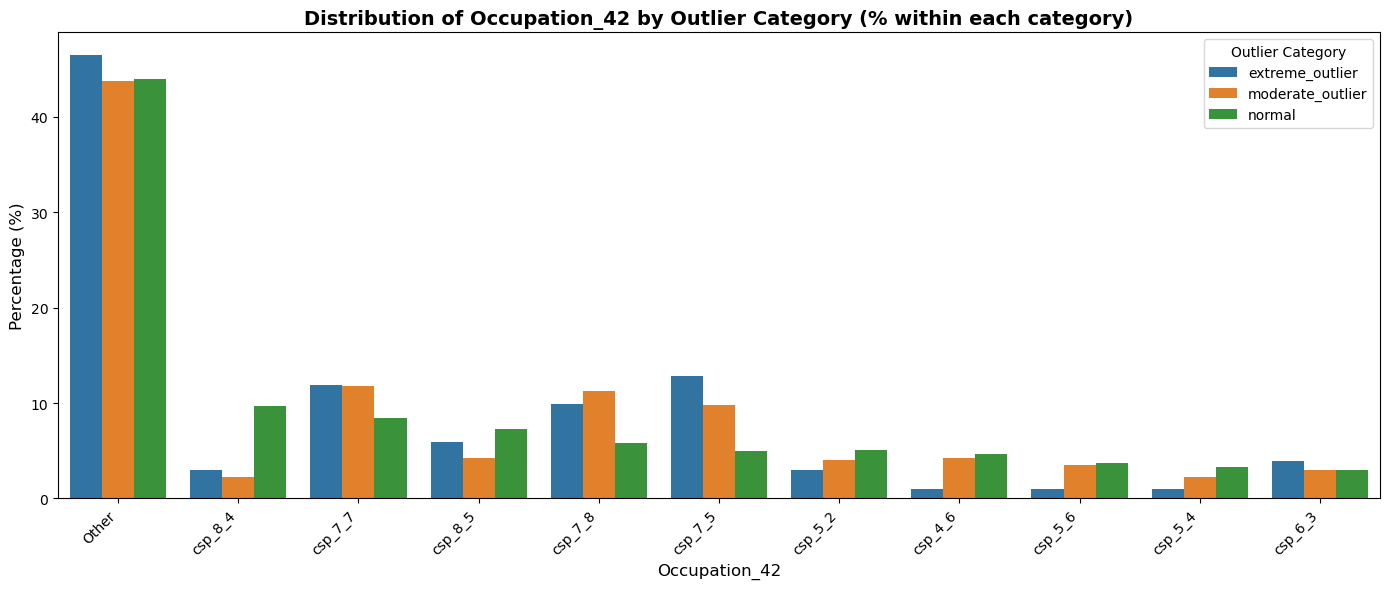


AGE_2018 has 89 unique values - showing top 10 categories


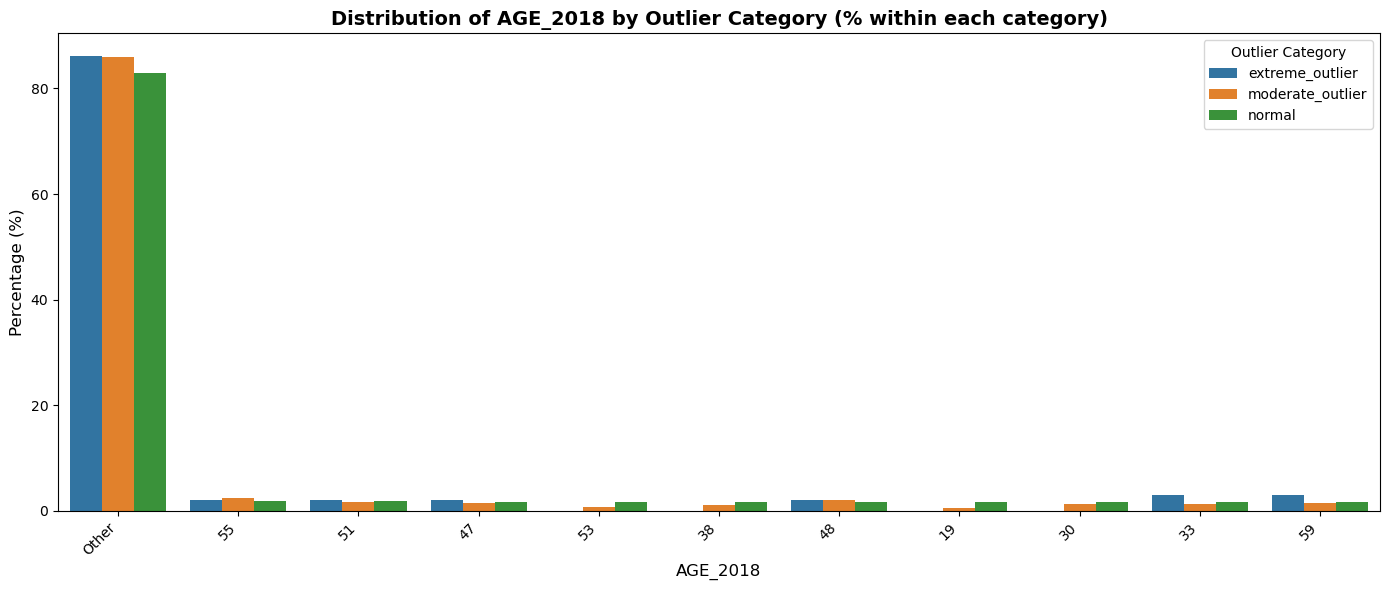


Sports has 88 unique values - showing top 10 categories


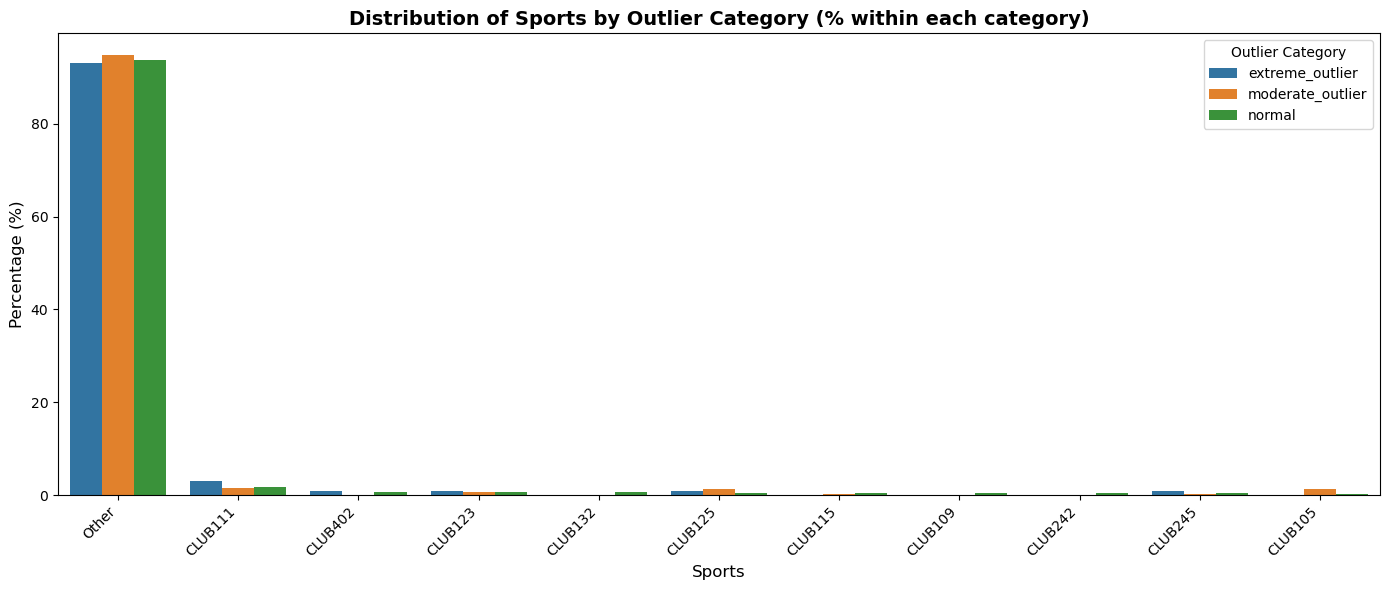

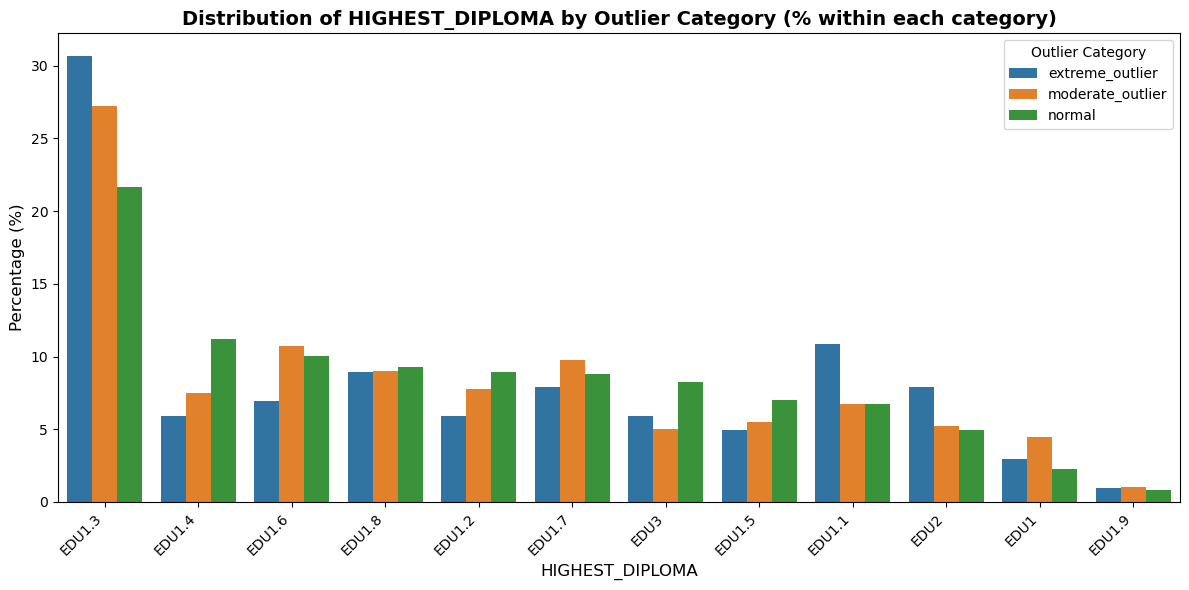


Occupation_42 has 41 unique values - showing top 10 categories


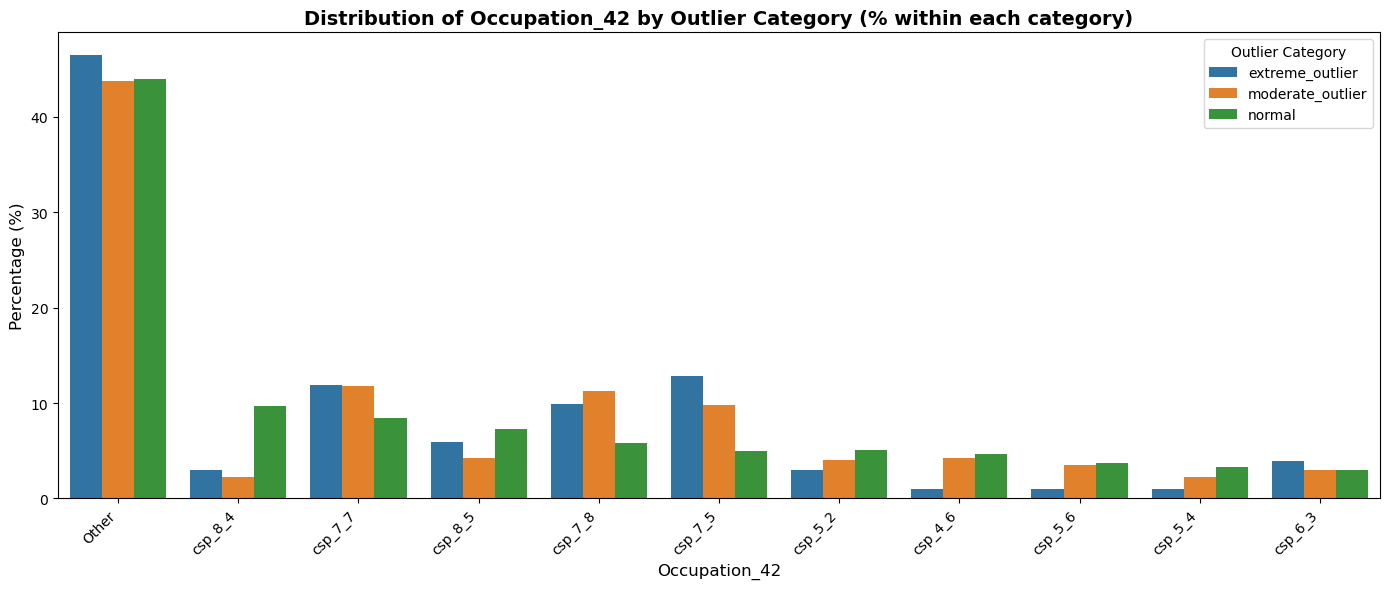


AGE_2018 has 89 unique values - showing top 10 categories


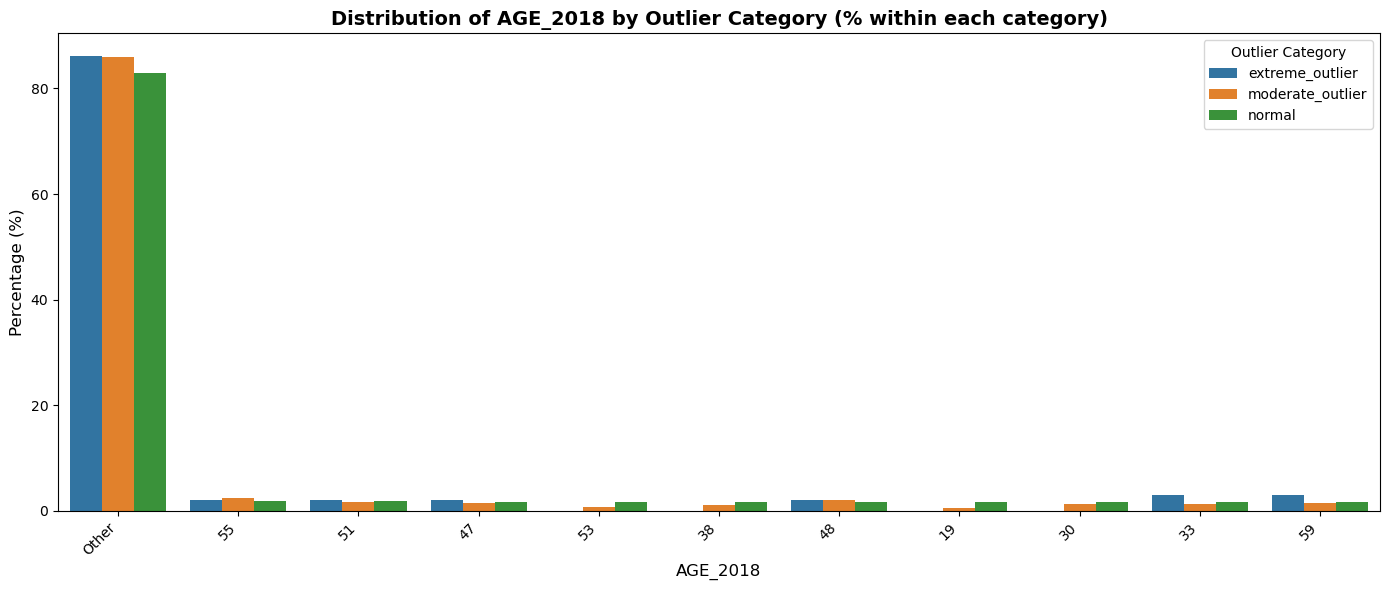

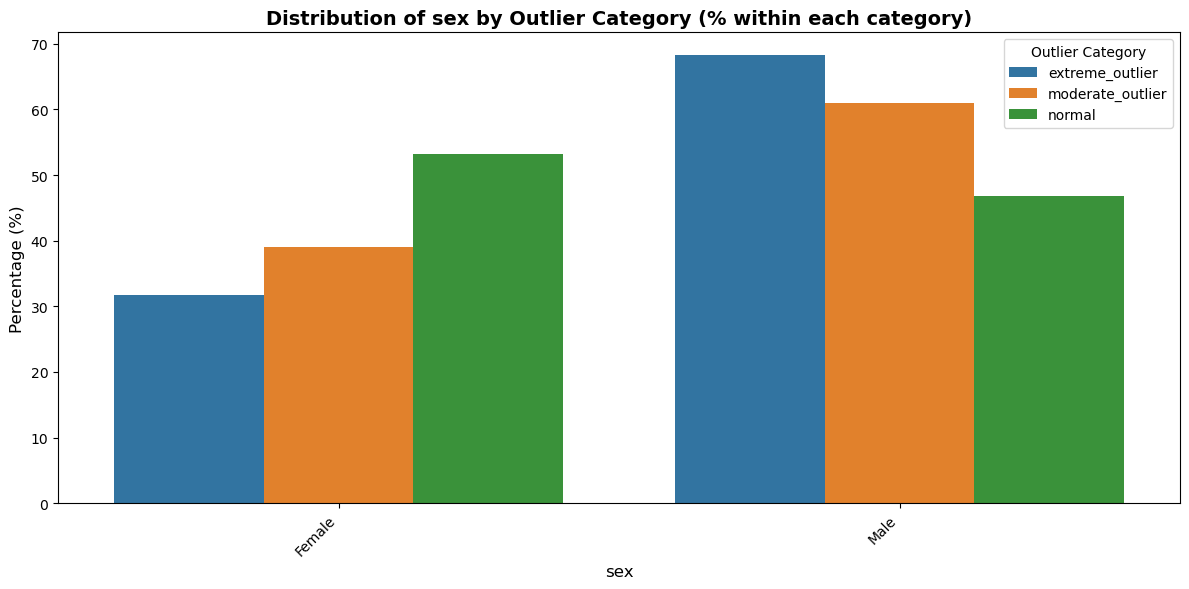


Sports has 88 unique values - showing top 10 categories


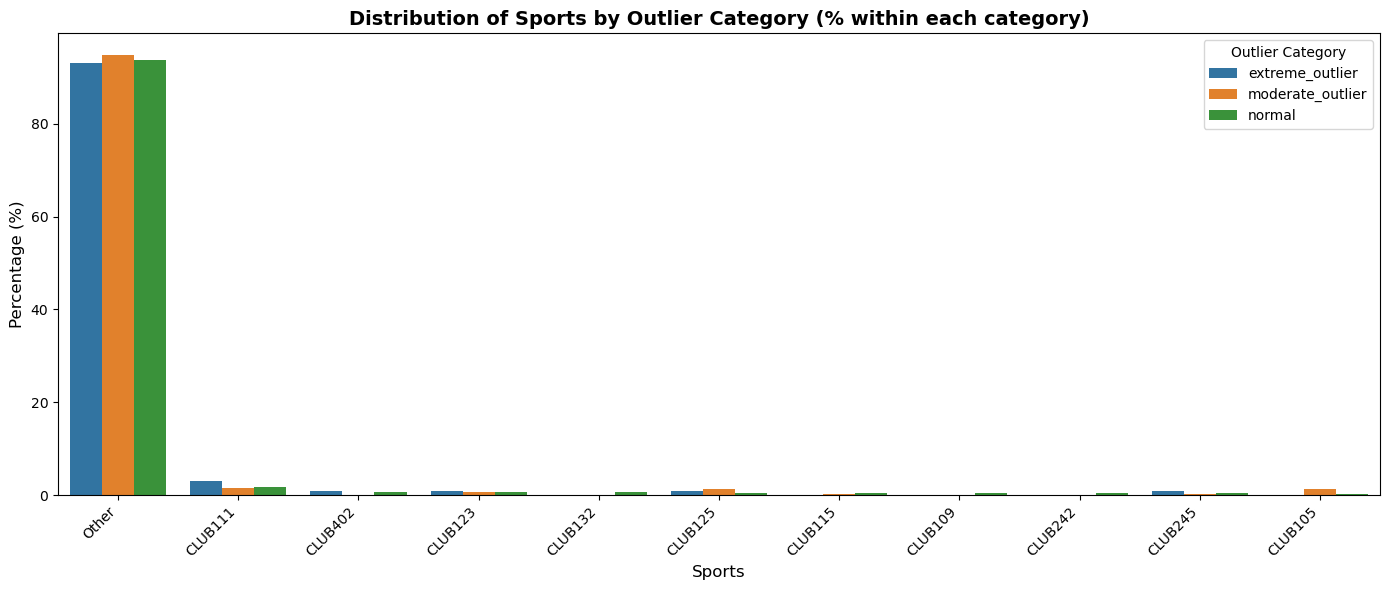

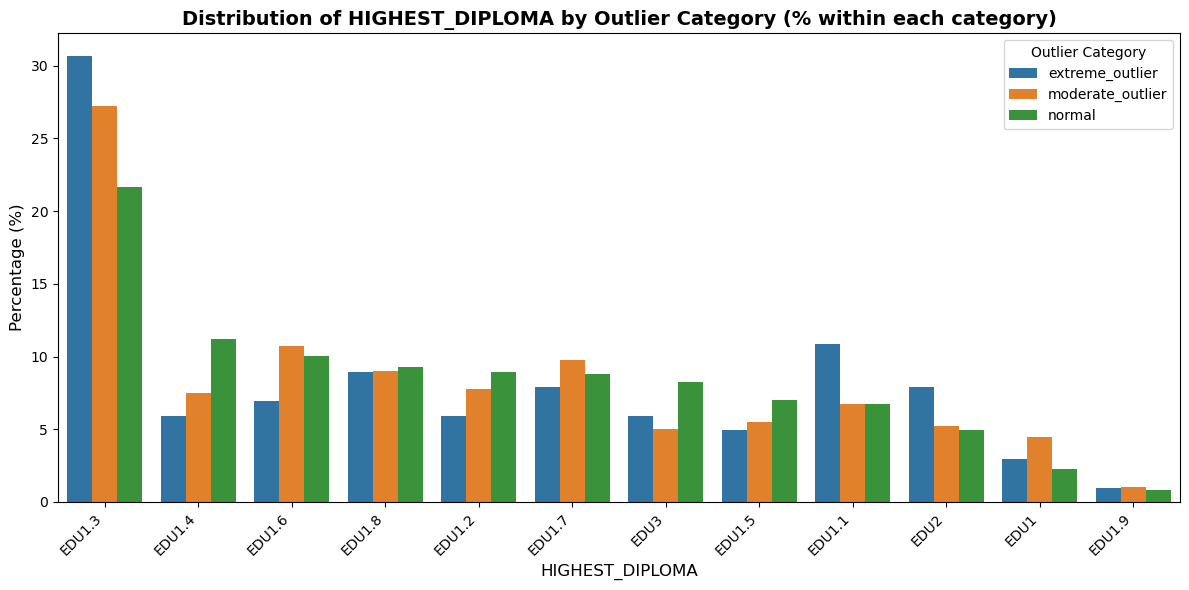


Occupation_42 has 41 unique values - showing top 10 categories


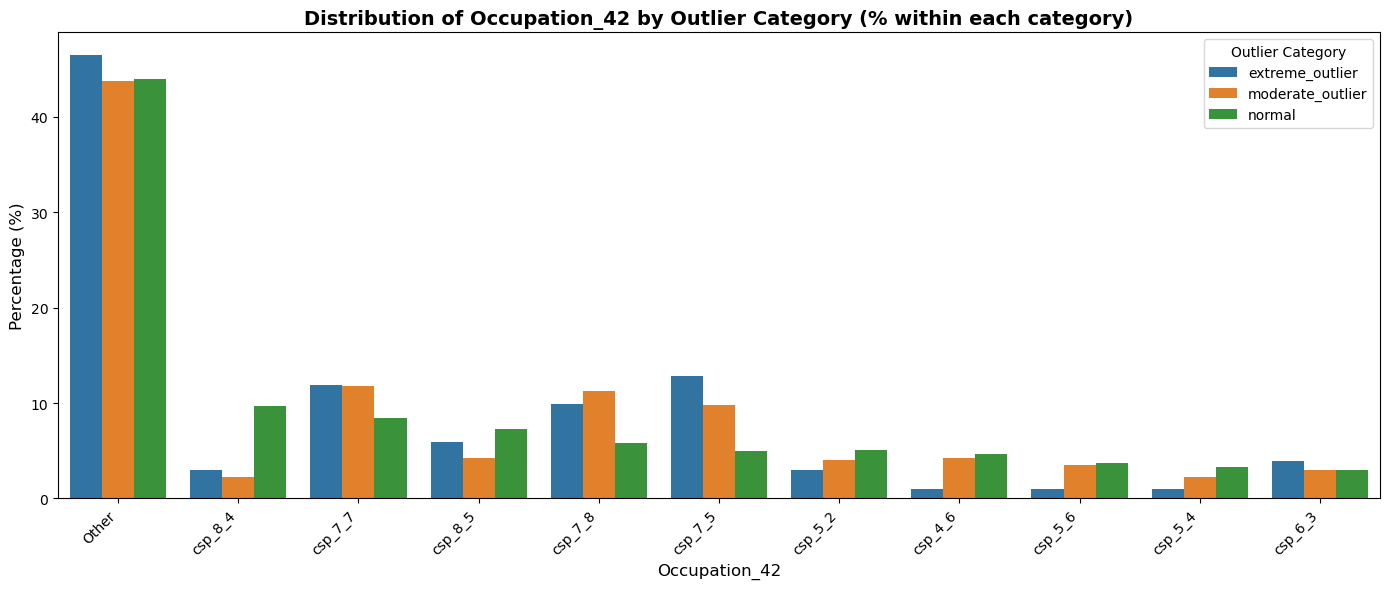


AGE_2018 has 89 unique values - showing top 10 categories


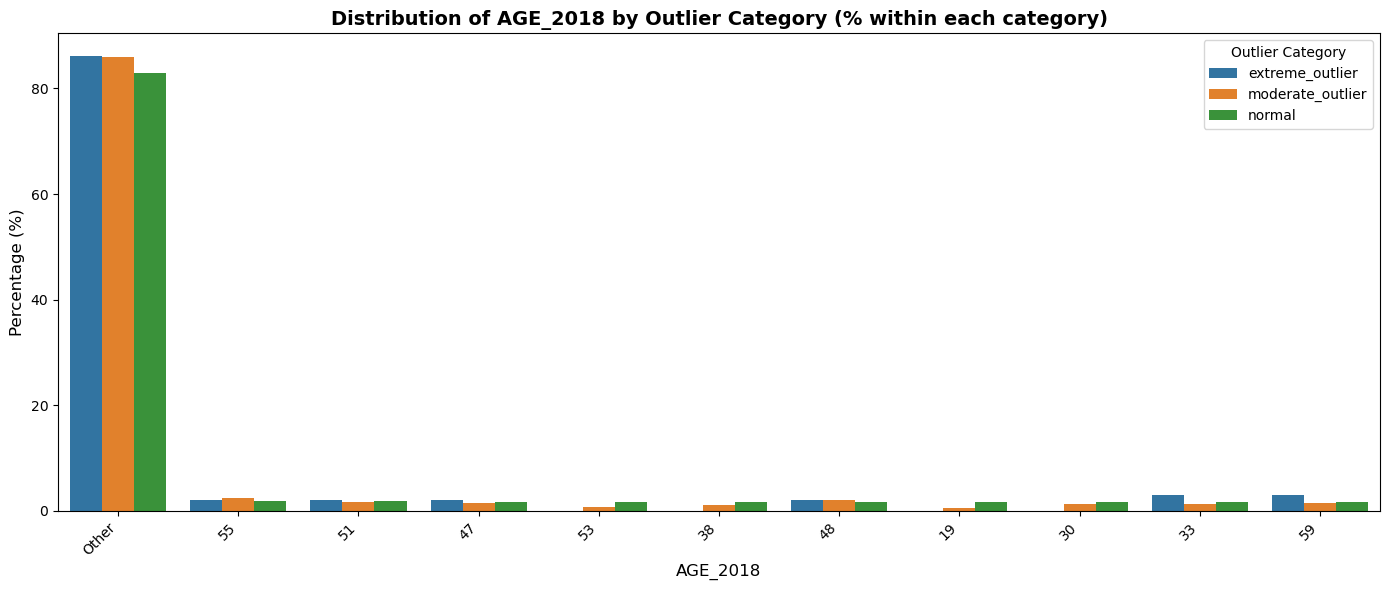

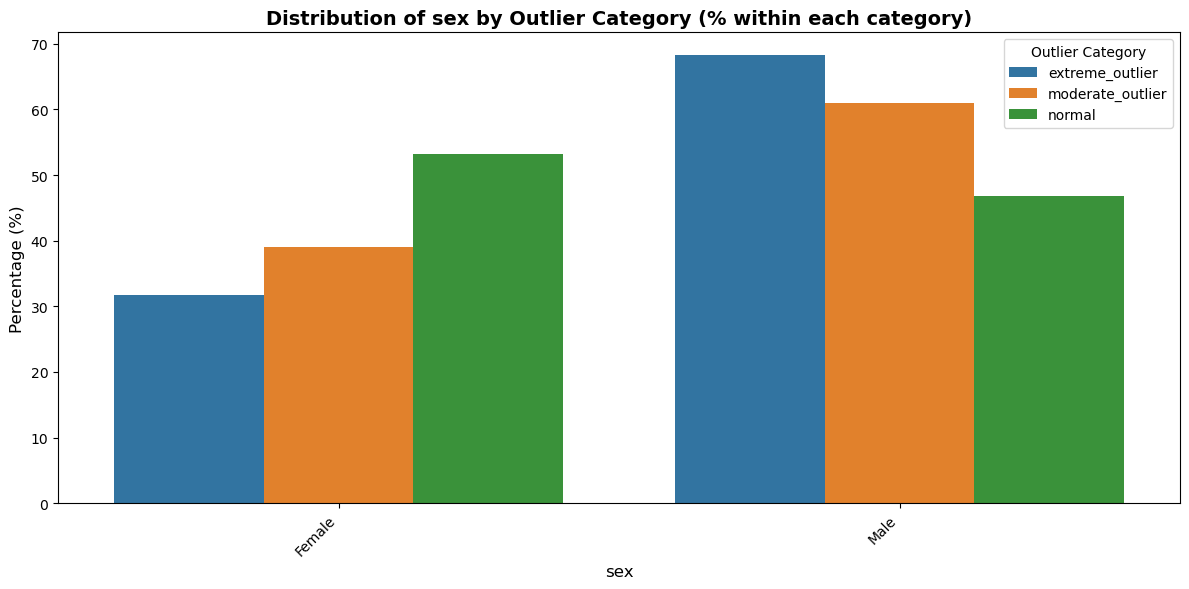

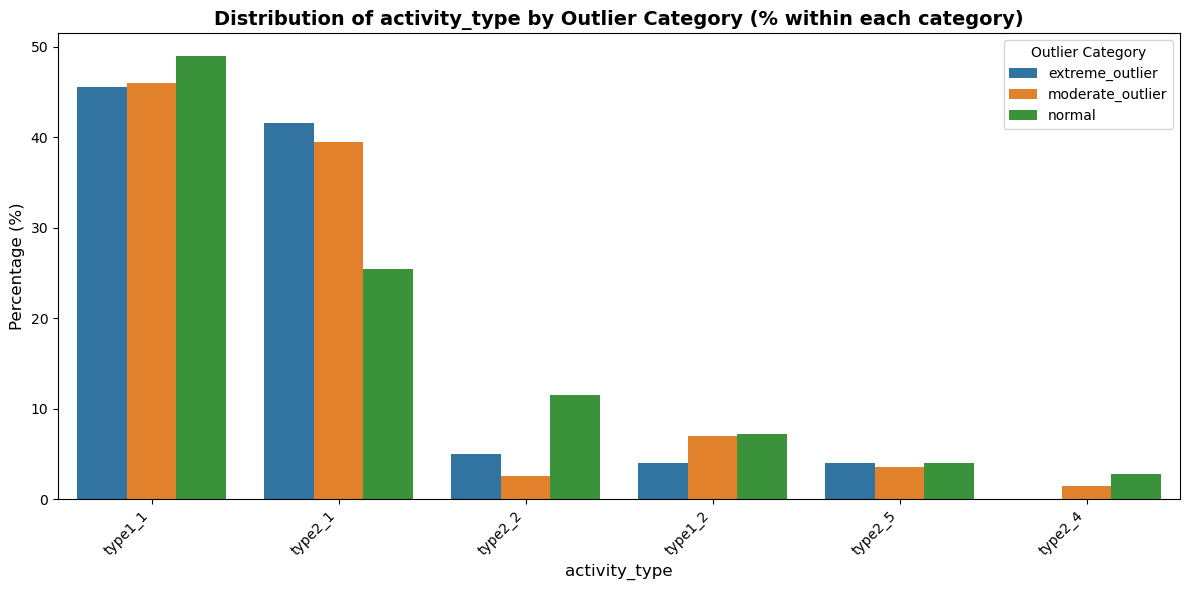


SUMMARY: Variable Cardinality
Sports                   :   88 unique values
HIGHEST_DIPLOMA          :   12 unique values
Occupation_42            :   41 unique values
AGE_2018                 :   89 unique values
sex                      :    2 unique values
activity_type            :    6 unique values


In [31]:
# Plot variable distribution for outliers vs non-outliers (as proportions)
import seaborn as sns  

variables_to_plot = ['Sports','department', 'HIGHEST_DIPLOMA', 'Occupation_42', 'AGE_2018', 'sex', 'activity_type']

# Identify high cardinality variables (> 15 unique values)
high_cardinality_threshold = 15

for var in variables_to_plot:
    if var not in outlier_df.columns:
        continue
    
    n_unique = outlier_df[var].nunique()
    
    if n_unique > high_cardinality_threshold:
        # For high cardinality variables: show top 10 categories + "Other"
        print(f"\n{var} has {n_unique} unique values - showing top 10 categories")
        
        # Get top 10 most frequent categories
        top_categories = outlier_df[var].value_counts().head(10).index.tolist()
        
        # Create a copy with "Other" category
        df_plot = outlier_df.copy()
        df_plot[f'{var}_grouped'] = df_plot[var].apply(
            lambda x: x if x in top_categories else 'Other'
        )
        
        # Calculate proportions for each outlier category
        prop_df = df_plot.groupby(['outlier_category', f'{var}_grouped']).size().reset_index(name='count')
        prop_df['total'] = prop_df.groupby('outlier_category')['count'].transform('sum')
        prop_df['proportion'] = prop_df['count'] / prop_df['total'] * 100
        
        # Order by overall frequency
        category_order = df_plot[f'{var}_grouped'].value_counts().index.tolist()
        
        # Plot
        plt.figure(figsize=(14, 6))
        sns.barplot(data=prop_df, x=f'{var}_grouped', y='proportion', 
                   hue='outlier_category', order=category_order)
        plt.title(f'Distribution of {var} by Outlier Category (% within each category)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel(var, fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Outlier Category')
        plt.tight_layout()
        plt.show()
        
    else:
        # For low cardinality variables: show all categories
        # Calculate proportions for each outlier category
        prop_df = outlier_df.groupby(['outlier_category', var]).size().reset_index(name='count')
        prop_df['total'] = prop_df.groupby('outlier_category')['count'].transform('sum')
        prop_df['proportion'] = prop_df['count'] / prop_df['total'] * 100
        
        # Order by overall frequency
        category_order = outlier_df[var].value_counts().index.tolist()
        
        # Plot
        plt.figure(figsize=(12, 6))
        sns.barplot(data=prop_df, x=var, y='proportion', 
                   hue='outlier_category', order=category_order)
        plt.title(f'Distribution of {var} by Outlier Category (% within each category)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel(var, fontsize=12)
        plt.ylabel('Percentage (%)', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Outlier Category')
        plt.tight_layout()
        plt.show()

# Print summary statistics
print("\n" + "=" * 80)
print("SUMMARY: Variable Cardinality")
print("=" * 80)
for var in variables_to_plot:
    if var in outlier_df.columns:
        n_unique = outlier_df[var].nunique()
        print(f"{var:25s}: {n_unique:4d} unique values")


In [32]:
# Load and merge test data using the same function
test_df, _, _, _, _ = load_and_merge_datasets('test')



Loading test datasets...
✓ Test datasets loaded: main(50042, 9), sport(6405, 2), job(19277, 11), retired_jobs(11282, 11), retired_pension(11282, 2)
✓ Merged test datasets: (50042, 50)
  - Current job columns: 13 (suffix: _current)
  - Retired job columns: 13 (suffix: _retired)
  - Pension columns: 1
  - Sport columns: 2


In [33]:
# Train the best model from HalvingRandomSearchCV on the whole learning set
print("=" * 60)
print("TRAINING FINAL MODEL ON COMPLETE DATASET")
print("=" * 60)

# Get the best estimator from the search
final_model = halving_search.best_estimator_

print(f"\nBest parameters found:")
for param, value in halving_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest cross-validation R² score: {halving_search.best_score_:.4f}")

# Train on the complete learning dataset
print(f"\nTraining on complete dataset with {len(X)} samples...")
final_model.fit(X, y)
print("✓ Final model trained successfully on complete learning set")

print("=" * 60)

TRAINING FINAL MODEL ON COMPLETE DATASET

Best parameters found:
  regressor__min_samples_leaf: 10
  regressor__max_leaf_nodes: 15
  regressor__max_iter: 300
  regressor__max_depth: None
  regressor__learning_rate: 0.1
  regressor__l2_regularization: 1.0

Best cross-validation R² score: 0.8277

Training on complete dataset with 50044 samples...

AAV2020 Encoder fitted:
  - Special categories: 8
  - Top 100 categories: 100
  - Total kept categories: 104
✓ Final model trained successfully on complete learning set


In [34]:
# Make predictions on test dataset
print("=" * 60)
print("MAKING PREDICTIONS ON TEST DATASET")
print("=" * 60)

# Drop primary_key and target if they exist in test_df
X_test_final = test_df.drop(columns=['primary_key', 'target'], errors='ignore')

print(f"\nTest dataset shape: {X_test_final.shape}")
print("Making predictions...")

# Make predictions using the final trained model
test_predictions = final_model.predict(X_test_final)

# Create results dataframe
results_df = pd.DataFrame({
    'primary_key': test_df['primary_key'],
    'target': test_predictions
})

# Save to CSV
results_df.to_csv('predictions.csv', index=False)

print(f"✓ Predictions saved to 'predictions.csv'")
print(f"  - Number of predictions: {len(results_df)}")
print(f"  - Prediction statistics:")
print(f"    • Mean: {test_predictions.mean():.2f}")
print(f"    • Median: {np.median(test_predictions):.2f}")
print(f"    • Min: {test_predictions.min():.2f}")
print(f"    • Max: {test_predictions.max():.2f}")
print("=" * 60)

MAKING PREDICTIONS ON TEST DATASET

Test dataset shape: (50042, 49)
Making predictions...


MAKING PREDICTIONS ON TEST DATASET

Test dataset shape: (50042, 49)
Making predictions...


TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''